# Single qubit gates
## First, isolated qubit

In [51]:
import numpy as np
from matplotlib import pyplot as plt
from qutip import*
from scipy.special import eval_hermite as hpoly
from scipy.optimize import minimize
import sys
#here, configure the path to the directory for pre-defined functions.
sys.path.append('/Users/longnguyen/Documents/GitHub/Fluxonium_berkeley/')
from Fluxonium_hamiltonians import qchard_fluxonium as fluxonium
from Fluxonium_hamiltonians import qchard_pshapes as pshapes
from Fluxonium_hamiltonians import qchard_evolgates as gates
import plotting_settings
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 400

In [52]:
savefig = False
from matplotlib import rcParams
if savefig == True:
    rcParams['font.family'] = 'serif'
    rcParams['font.serif'] = ['Times New Roman']
else:
    rcParams['font.family'] = 'sans-serif'
    rcParams['font.serif'] = ['Arial']
    
figpath = '/Users/longnguyen/Google Drive/LBL Research/Illustration/'

In [131]:
#Device parameters
nlev_lc = 30
nlev_single = 5  # The number of single-qubit levels to show.
take_data_from_input_file = False

if not take_data_from_input_file:
    # Parameters of the first fluxonium.
    E_L = 0.7  # inductive energy
    E_C = 1.0  # charging energy
    E_J = 3.5  # Josephson energy
    phi_ext = np.pi  # external phase shift

qubit = fluxonium.Fluxonium(E_J = E_J, E_C=E_C, E_L=E_L, phi_ext=phi_ext, nlev = nlev_single, nlev_lc = nlev_lc)

#Gate parameter
T_gate = 5 #ns
t_points = np.linspace(0, T_gate, 20 * int(T_gate) + 1)
drive_amplitude_factor = 1
delta_omega_d = 0
shape = 'gauss'
sigma = 0.25
drag = True
drag_coeff = 0.0

comp_space = [0,1]
omega_d = qubit.freq(0,1) + delta_omega_d
matr_el = np.abs(qubit.n_ij(0,1))
epsilon = drive_amplitude_factor/matr_el
H_drive = epsilon*(qubit.n())
H_dummy = 0*(qubit.n())
U_t = gates.evolution_operator_microwave(
                qubit.H(), H_drive, t_points=t_points, DRAG = drag, DRAG_coefficient = drag_coeff,
                T_gate=T_gate, shape=shape, sigma=sigma, omega_d=omega_d)
U_nothing = gates.evolution_operator_microwave(
                -qubit.H(), H_dummy, t_points=t_points, DRAG = drag, DRAG_coefficient = drag_coeff,
                T_gate=T_gate, shape=shape, sigma=sigma, omega_d=omega_d)

93.47583307775298


Text(0.5, 1.0, '$\\mathcal{F}=$0.934758')

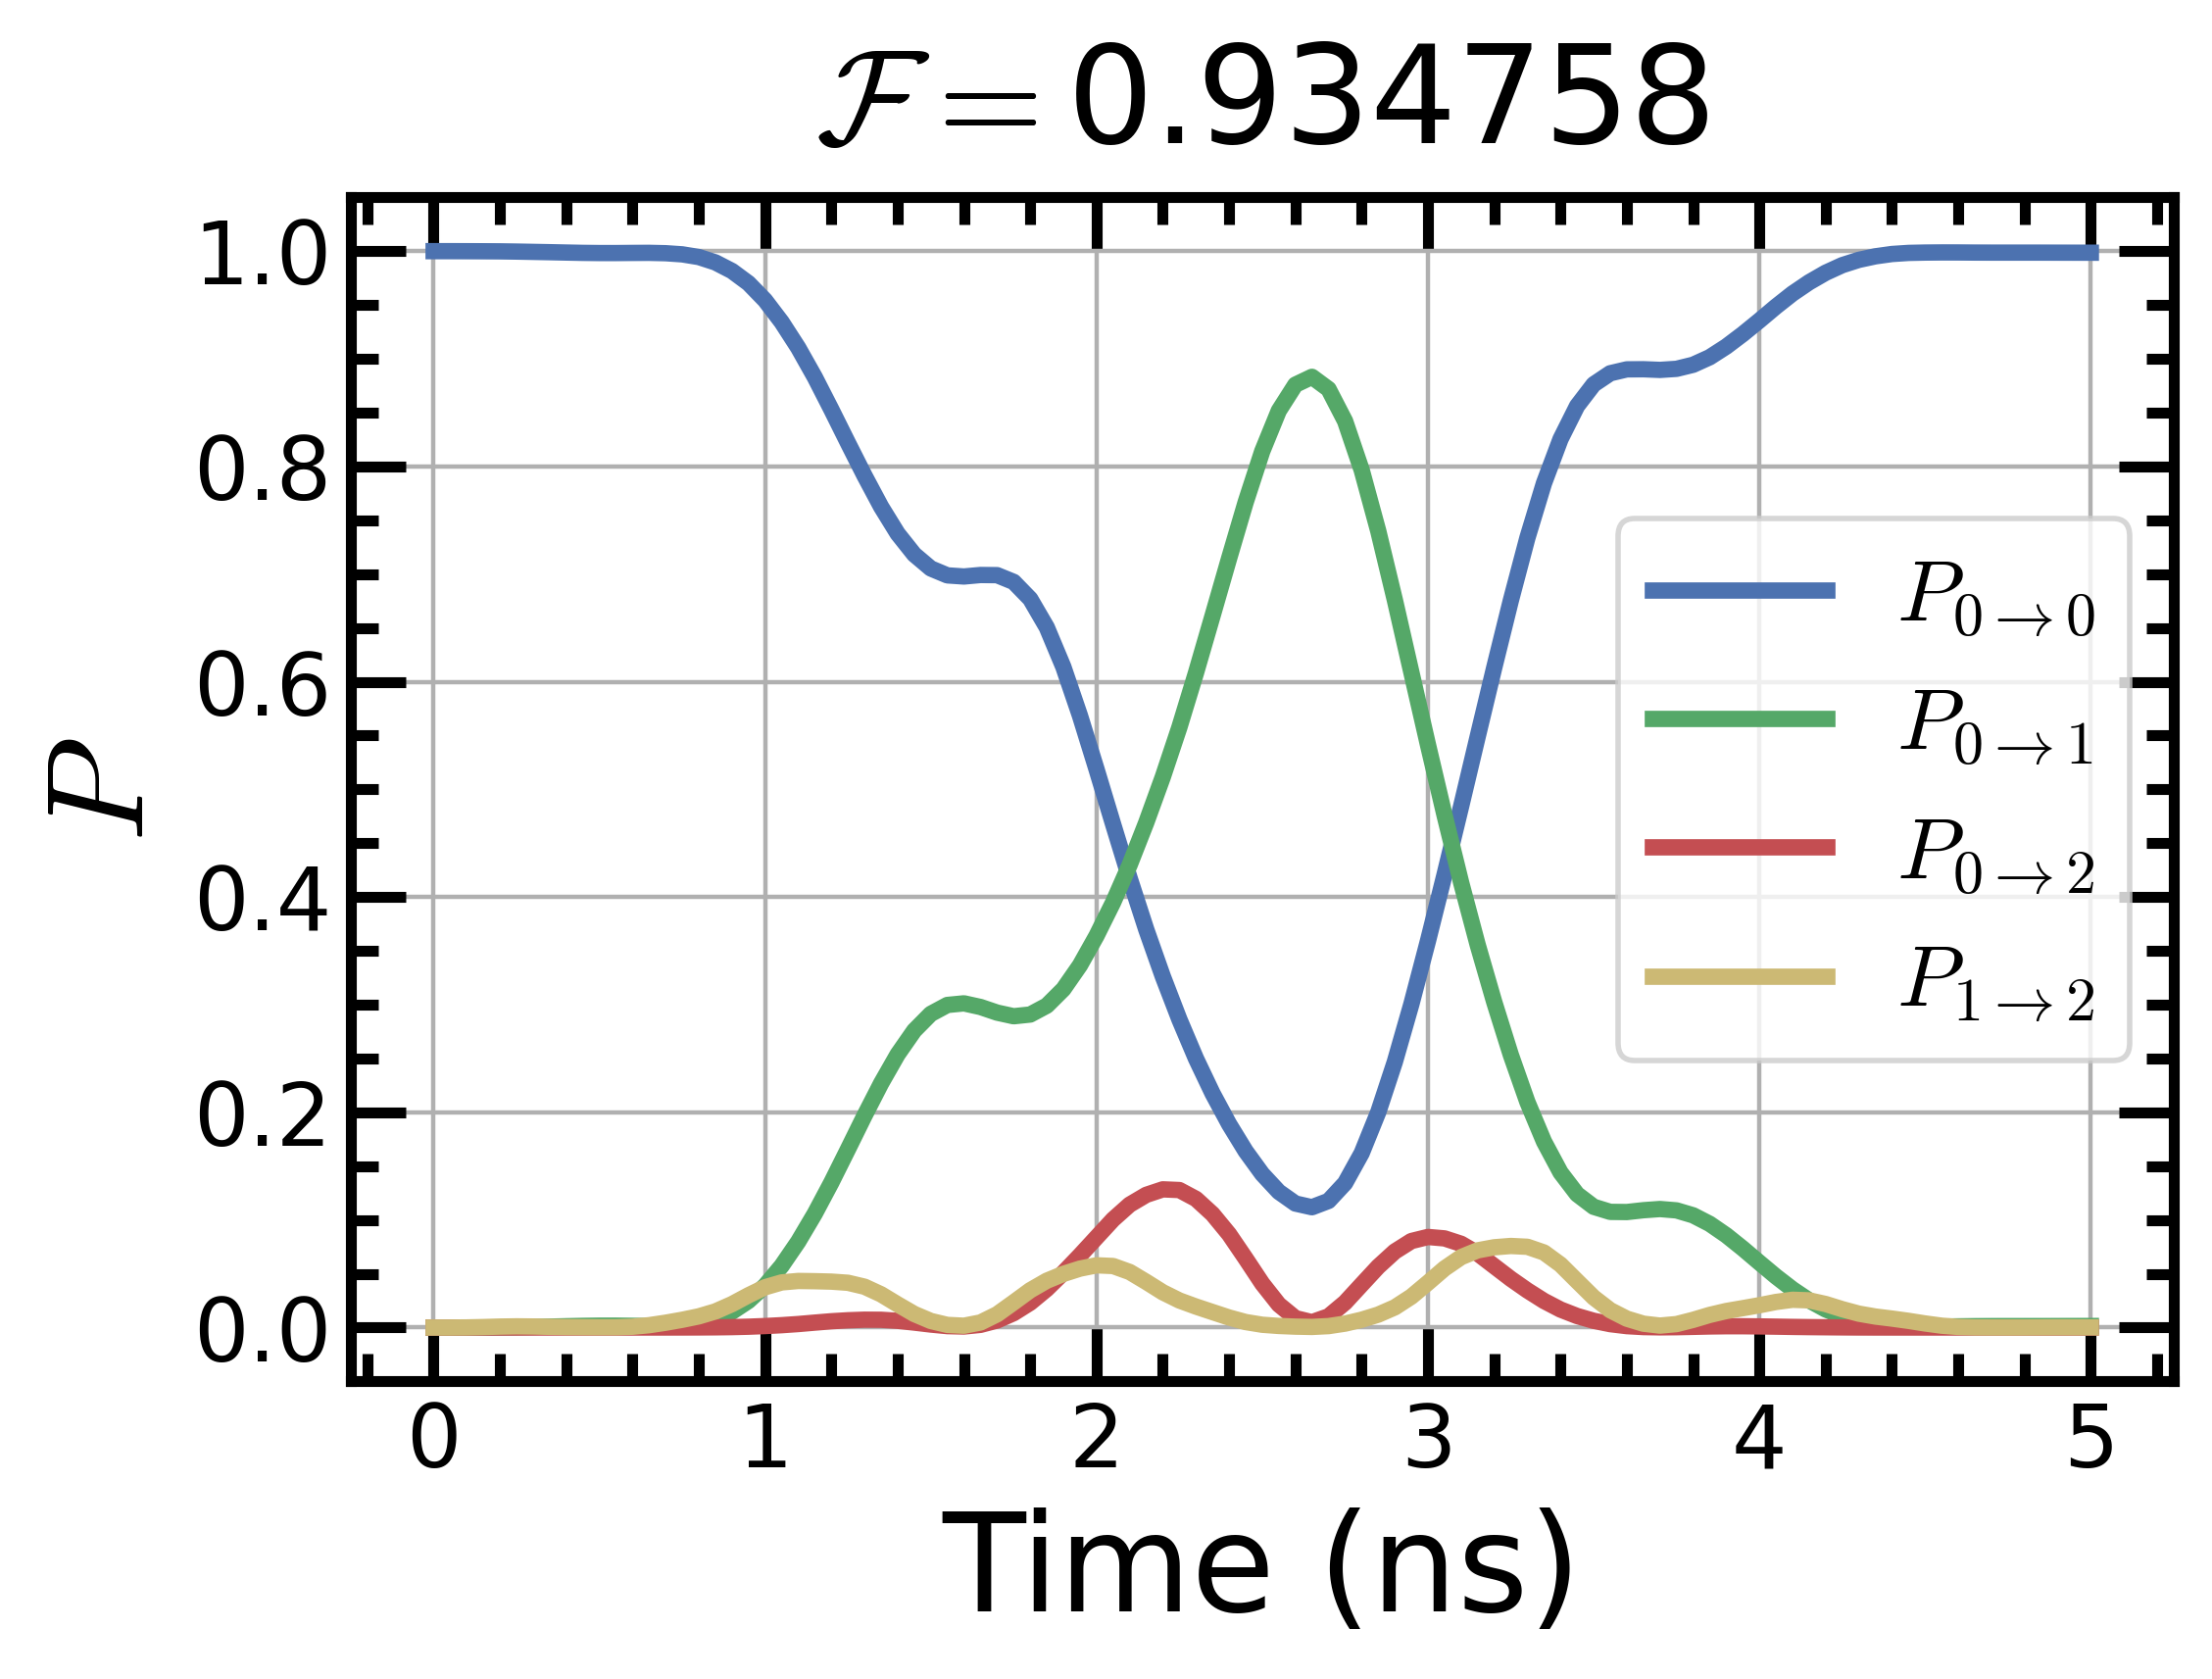

In [132]:
#Plotting results
state_0 = basis(nlev_single,0)
state_1 = basis(nlev_single,1)
state_2 = basis(nlev_single,2)
state_3 = basis(nlev_single,3)

#Fidelity
U_ideal = qeye(2)
U_real = U_nothing[-1]*U_t[-1]
U_real = Qobj(U_real[0:2, 0:2])

op1 = U_real.dag() * U_real
op2 = U_real * U_ideal.dag()
fidel = (op1.tr() + (abs(op2.tr())) ** 2) / 6.0
print(fidel*100)

trans_prob_0 = gates.prob_transition(U_t, state_0, state_0)
trans_prob_1 = gates.prob_transition(U_t, state_0, state_1)
trans_prob_2 = gates.prob_transition(U_t, state_0, state_2)
trans_prob_3 = gates.prob_transition(U_t, state_1, state_2)
plt.plot(t_points, trans_prob_0, label=r'$P_{0\rightarrow 0}$')
plt.plot(t_points, trans_prob_1, label=r'$P_{0\rightarrow 1}$')
plt.plot(t_points, trans_prob_2, label=r'$P_{0\rightarrow 2}$')
plt.plot(t_points, trans_prob_3, color = 'C4', label=r'$P_{1\rightarrow 2}$')
plt.xlabel('Time (ns)')
plt.ylabel(r'$P$')
plt.legend()
plt.grid()
plt.title(r'$\mathcal{F}=$'+str(np.round(fidel,6)))

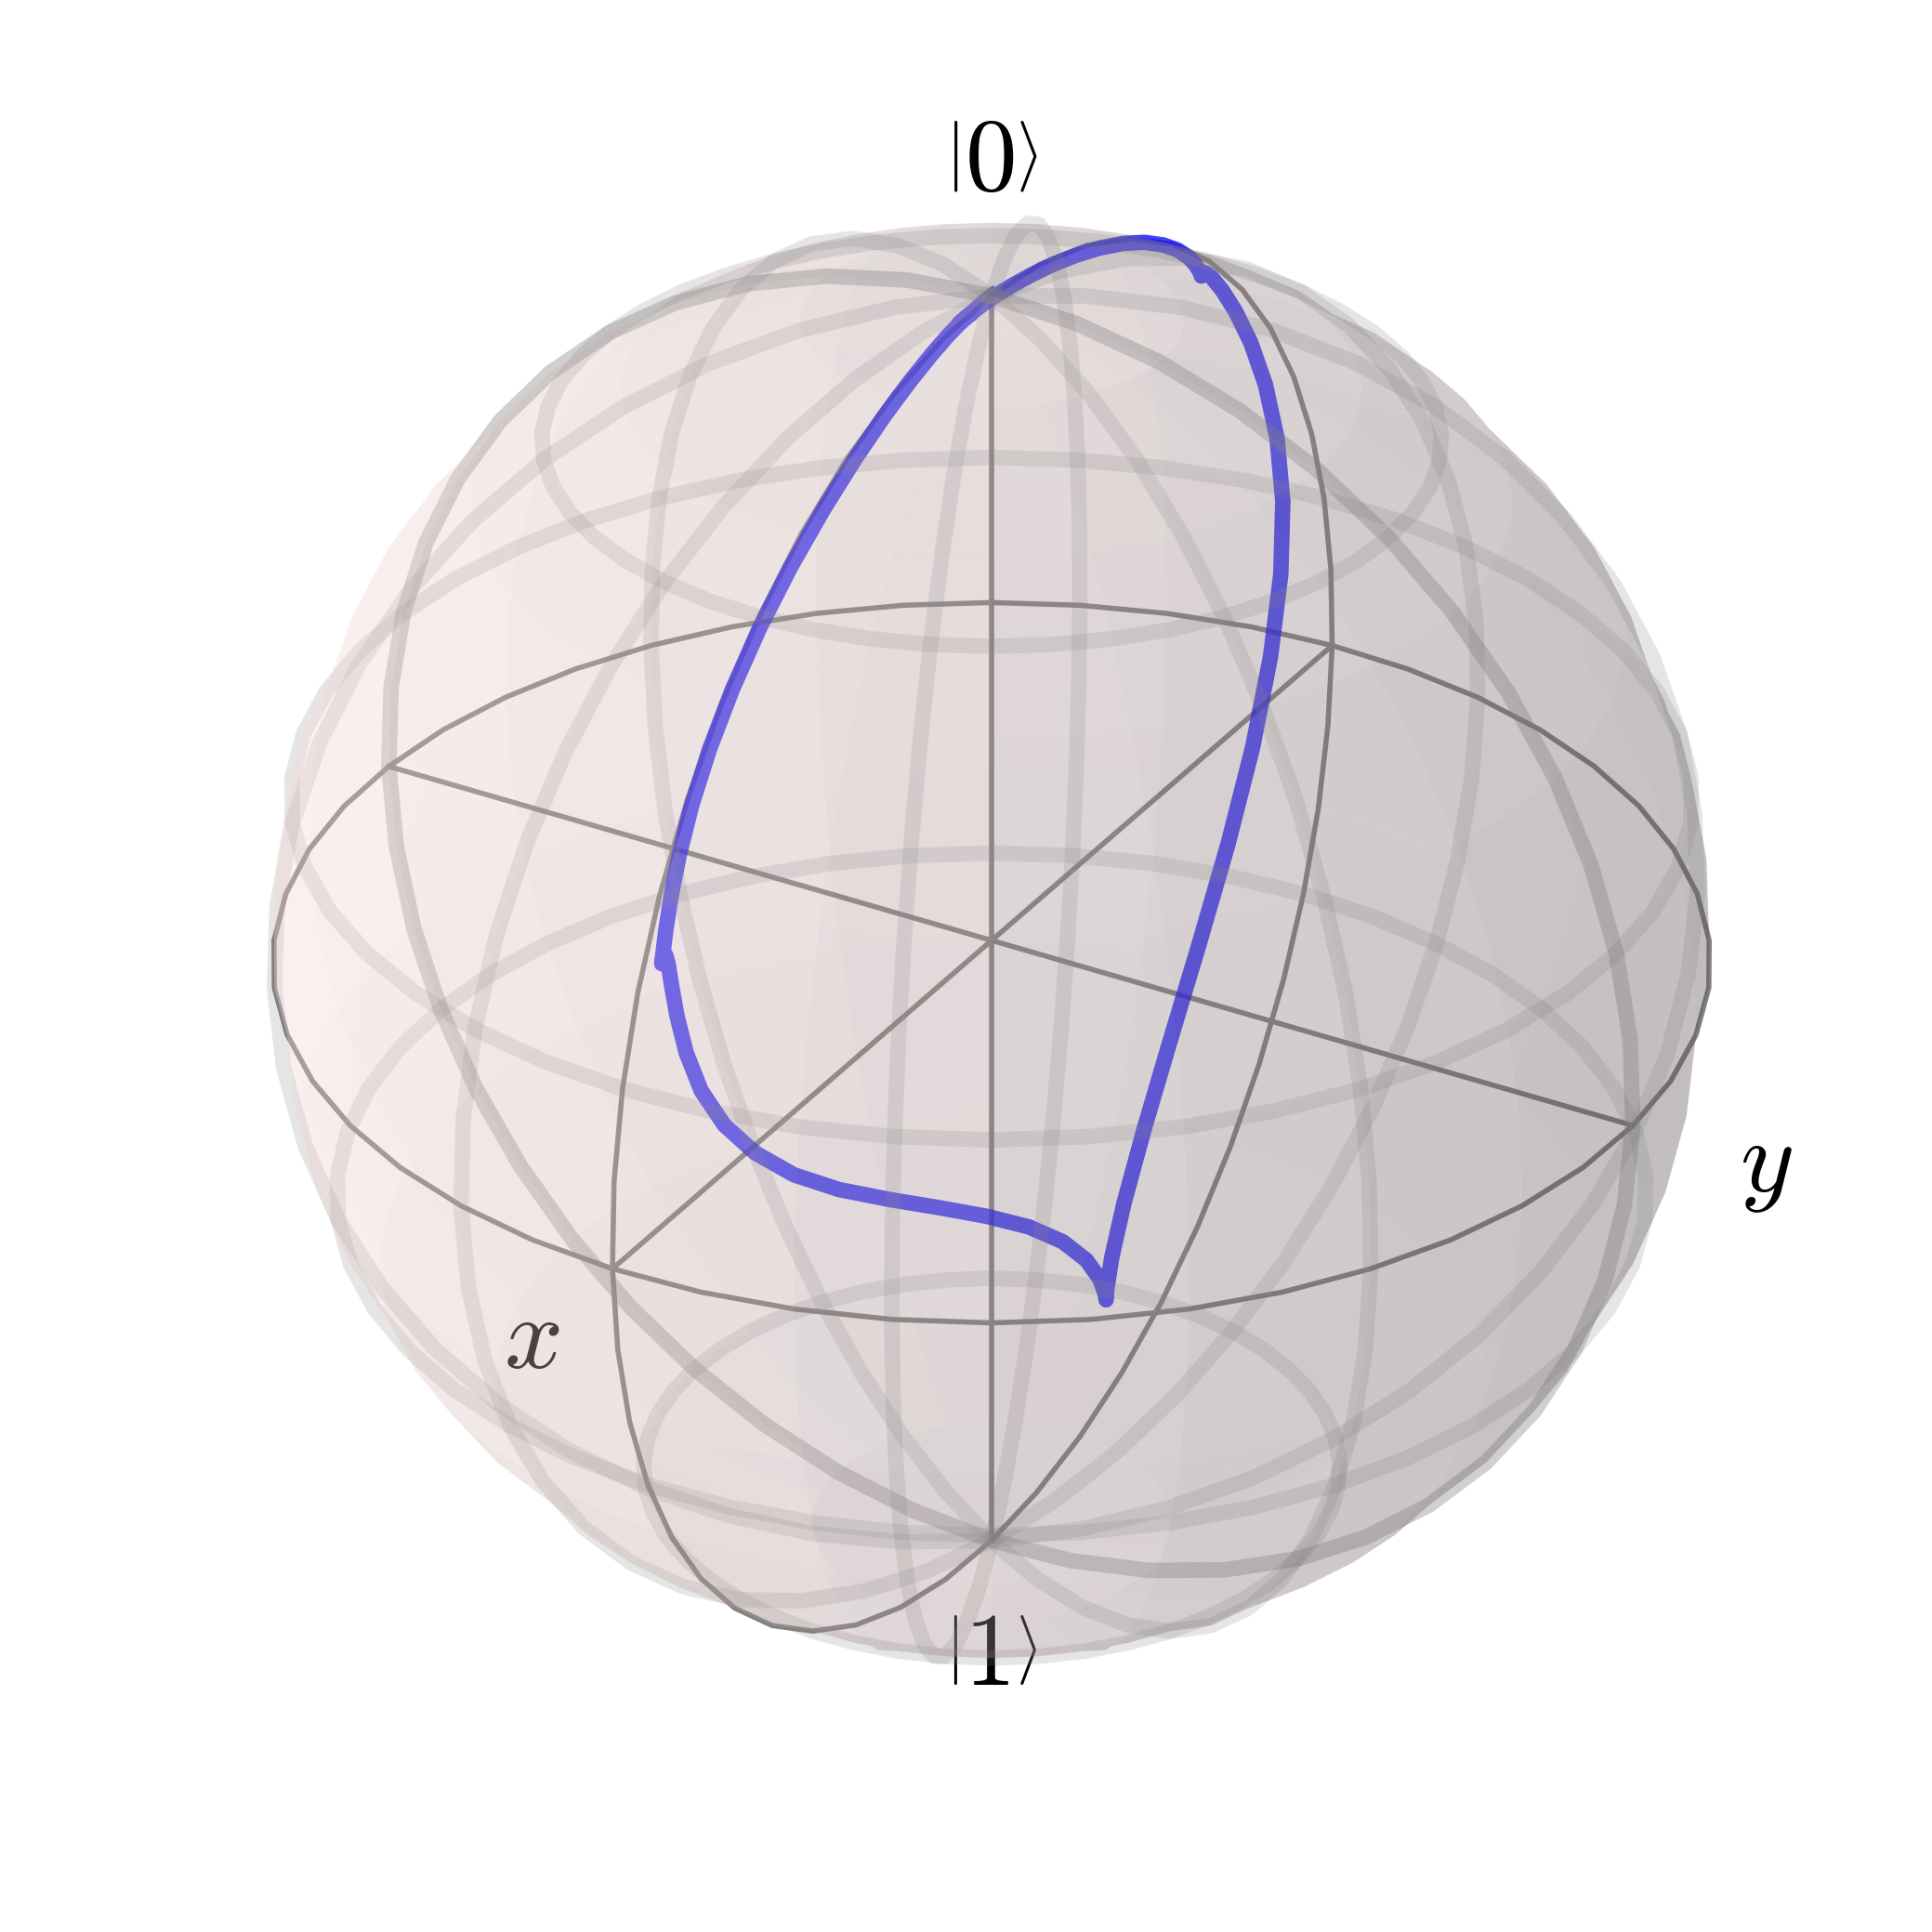

In [133]:
# Trajectory on Bloch sphere
state_evol = U_nothing * U_t * state_0

sz = np.real(expect(state_0*state_0.dag() - state_1*state_1.dag(),state_evol))
sx = np.real(expect(state_0*state_1.dag()+state_0*state_1.dag(),state_evol))
sy = np.real(expect(-1j*state_0*state_1.dag() + 1j*state_0*state_1.dag(),state_evol))

b = Bloch()
b.add_points([sx, sy, sz], meth ='l')
b.make_sphere()


In [114]:
# What is the frequency of 0-1?
print (qubit.level(1)-qubit.level(0))

0.47258884682534164


### Optimization

In [115]:
drag_coeff_array = np.linspace(0,1,101)
error_array = np.zeros_like(drag_coeff_array)
for idx, drag_coeff in enumerate(drag_coeff_array):
    U_t = gates.evolution_operator_microwave(
                qubit.H(), H_drive, t_points=t_points, DRAG = drag, DRAG_coefficient = drag_coeff,
                T_gate=T_gate, shape=shape, sigma=sigma, omega_d=omega_d)
    U_real = U_nothing[-1]*U_t[-1]
    U_real = Qobj(U_real[0:2, 0:2])

    op1 = U_real.dag() * U_real
    op2 = U_real * U_ideal.dag()
    fidel = (op1.tr() + (abs(op2.tr())) ** 2) / 6.0
    error_array[idx] = 1 - fidel

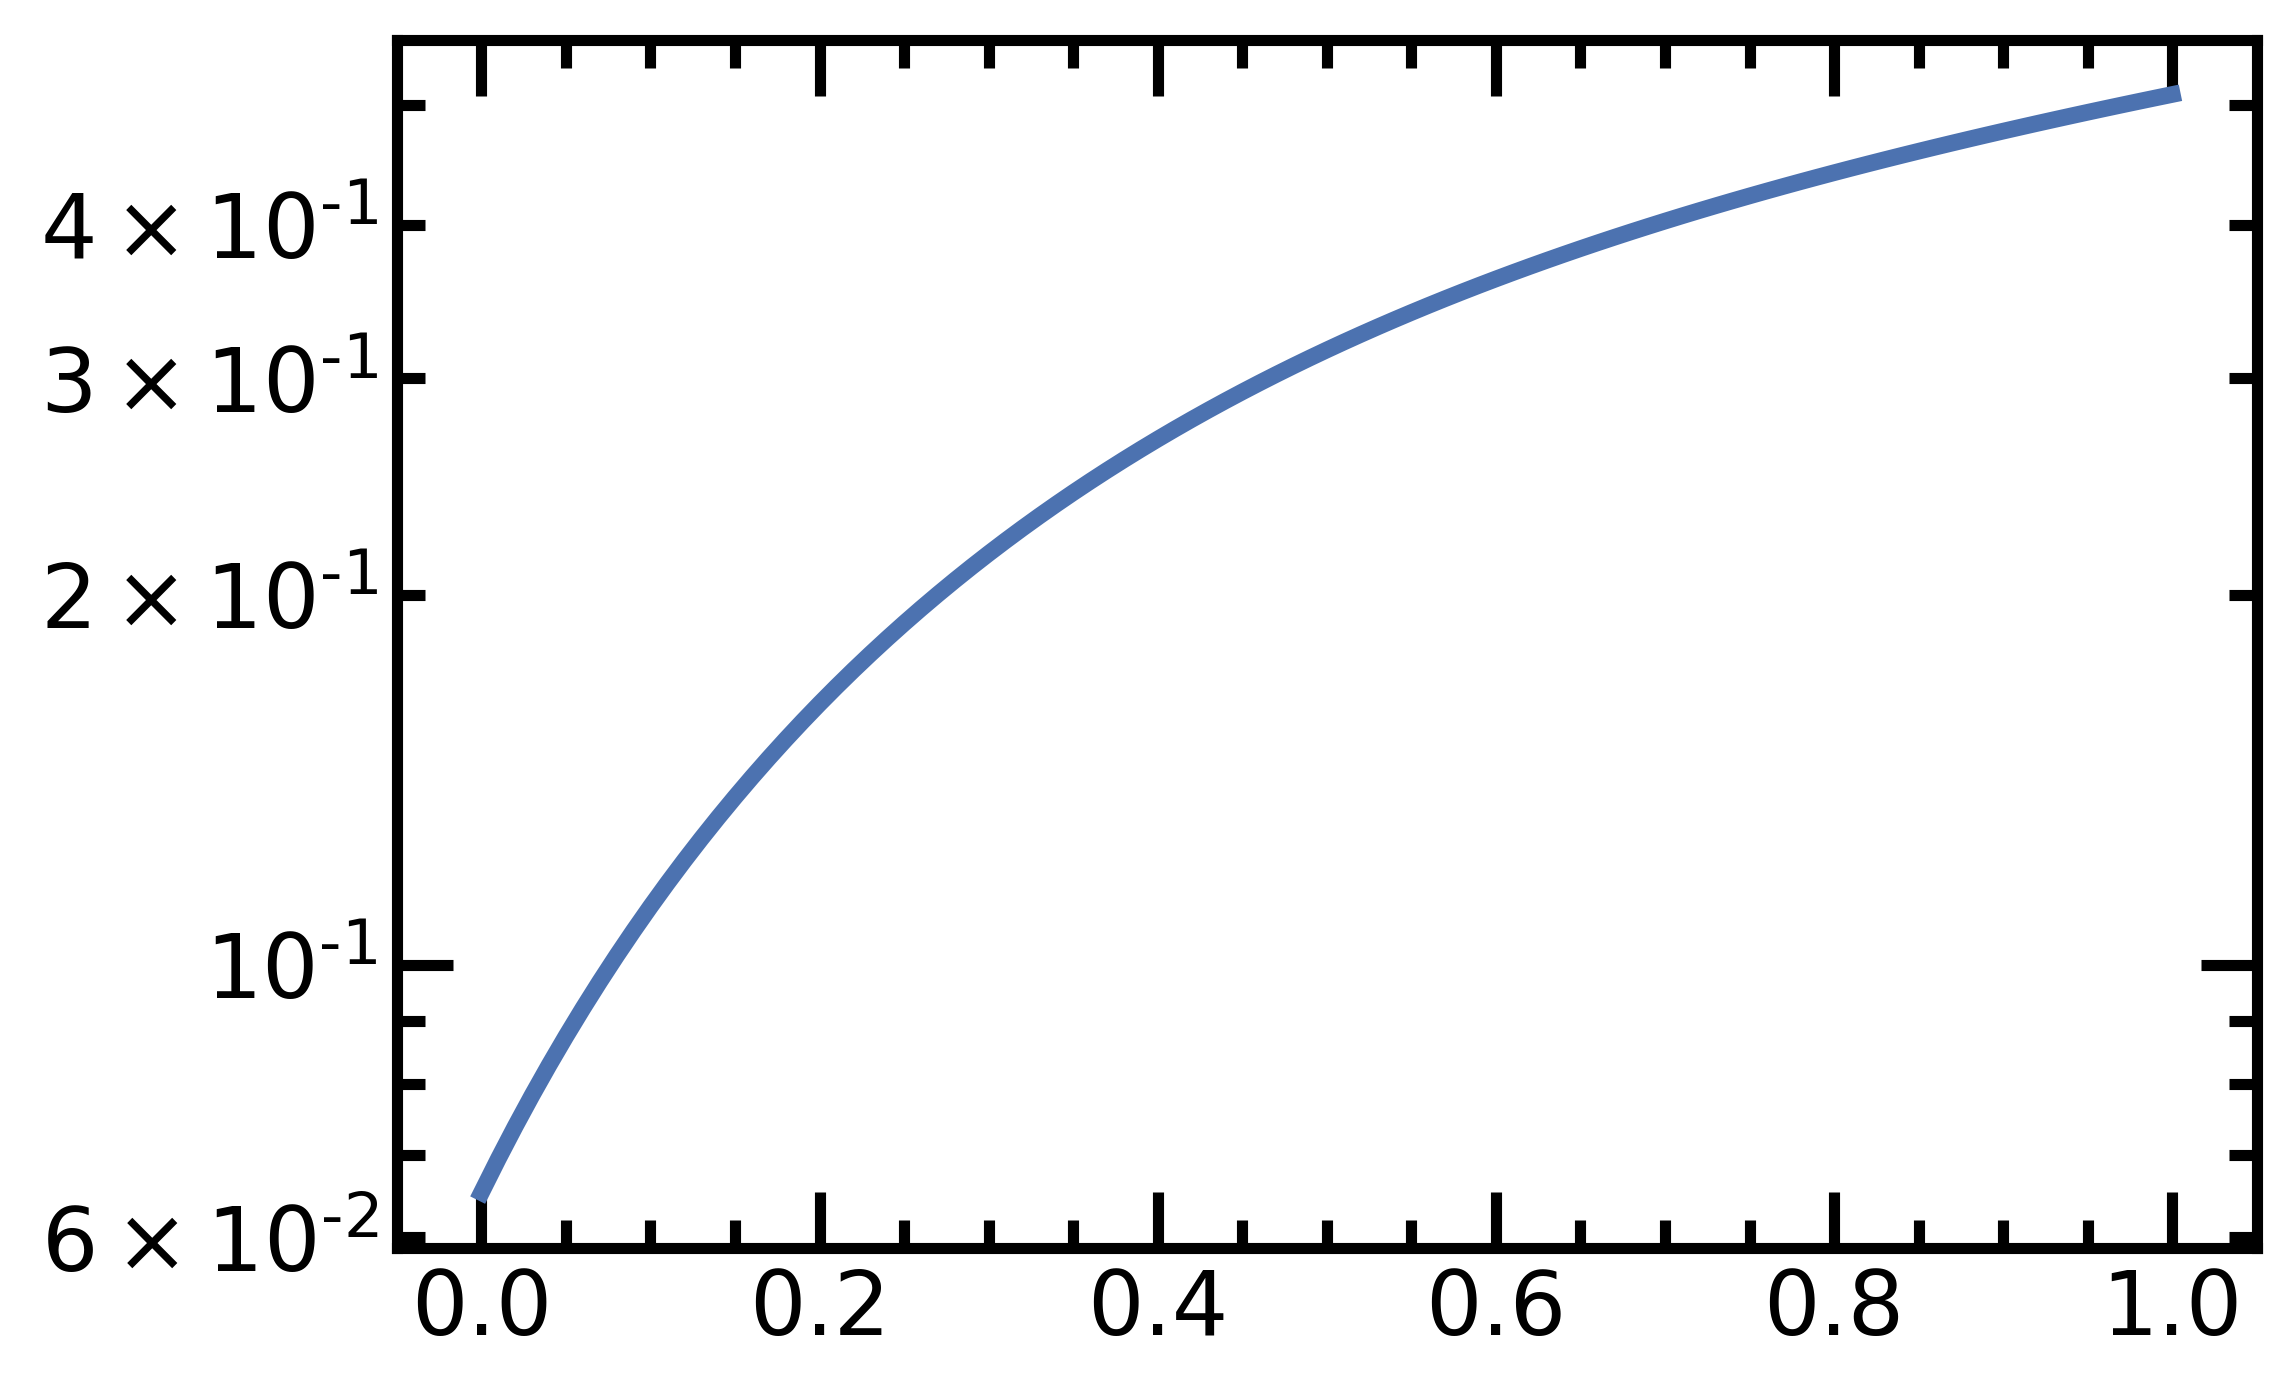

In [116]:
plt.semilogy (drag_coeff_array, error_array)

In [117]:
drag_coeff = 0
delta_omega_d_array = np.linspace(-0.04,-0.02,21)
error_array = np.zeros_like(delta_omega_d_array)
for idx, delta_omega_d in enumerate(delta_omega_d_array):
    omega_d = qubit.freq(0,1) + delta_omega_d
    U_t = gates.evolution_operator_microwave(
                qubit.H(), H_drive, t_points=t_points, DRAG = drag, DRAG_coefficient = drag_coeff,
                T_gate=T_gate, shape=shape, sigma=sigma, omega_d=omega_d)
    U_real = U_nothing[-1]*U_t[-1]
    U_real = Qobj(U_real[0:2, 0:2])

    op1 = U_real.dag() * U_real
    op2 = U_real * U_ideal.dag()
    fidel = (op1.tr() + (abs(op2.tr())) ** 2) / 6.0
    error_array[idx] = 1 - fidel

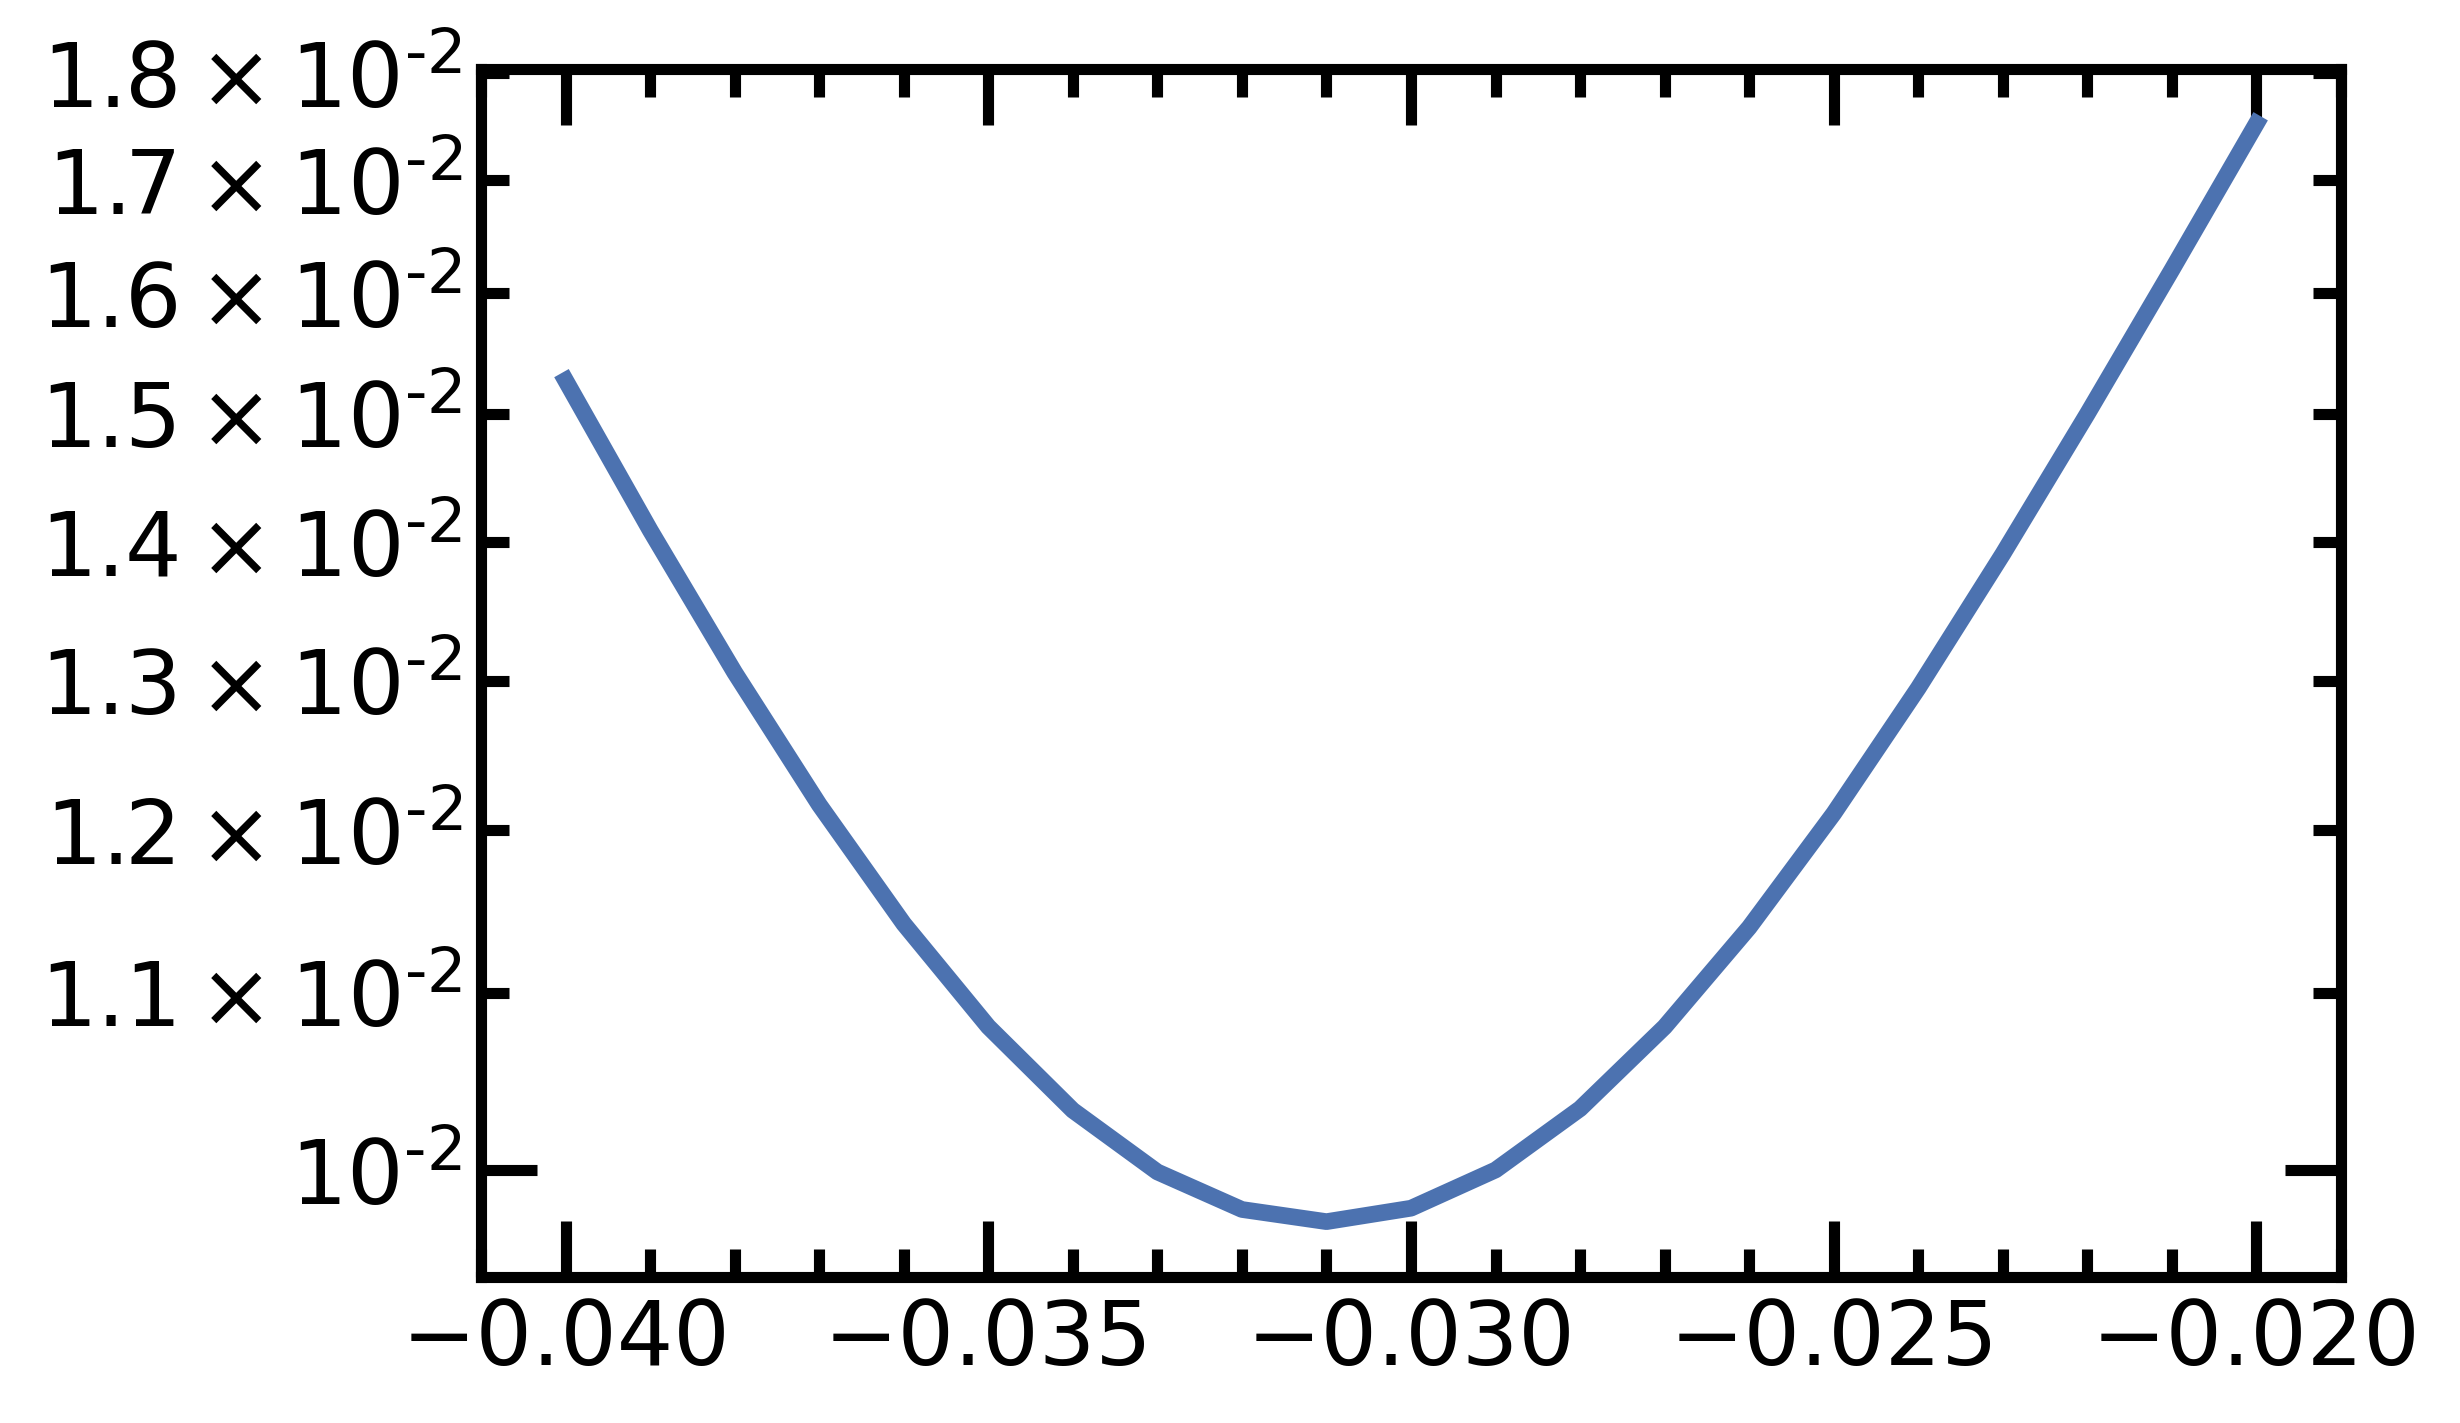

In [118]:
plt.semilogy (delta_omega_d_array, error_array)

In [119]:
def infidelity(x):
    delta_omega_d = x[0]
    drag_coeff = x[1]
    omega_d = qubit.freq(0,1) + delta_omega_d
    U_t = gates.evolution_operator_microwave(
                qubit.H(), H_drive, t_points=t_points, DRAG = drag, DRAG_coefficient = drag_coeff,
                T_gate=T_gate, shape=shape, sigma=sigma, omega_d=omega_d)
    U_real = U_nothing[-1]*U_t[-1]
    U_real = Qobj(U_real[0:2, 0:2])

    op1 = U_real.dag() * U_real
    op2 = U_real * U_ideal.dag()
    fidel = (op1.tr() + (abs(op2.tr())) ** 2) / 6.0
    return 1-fidel

x0 = [0,0]
xopt = minimize(infidelity, x0, method ='Powell', tol = 1e-6)
print (xopt.x)

[-0.06659393  0.25345345]


7.394147769290704e-06


Text(0.5, 1.0, '$\\mathcal{F}=$0.999993')

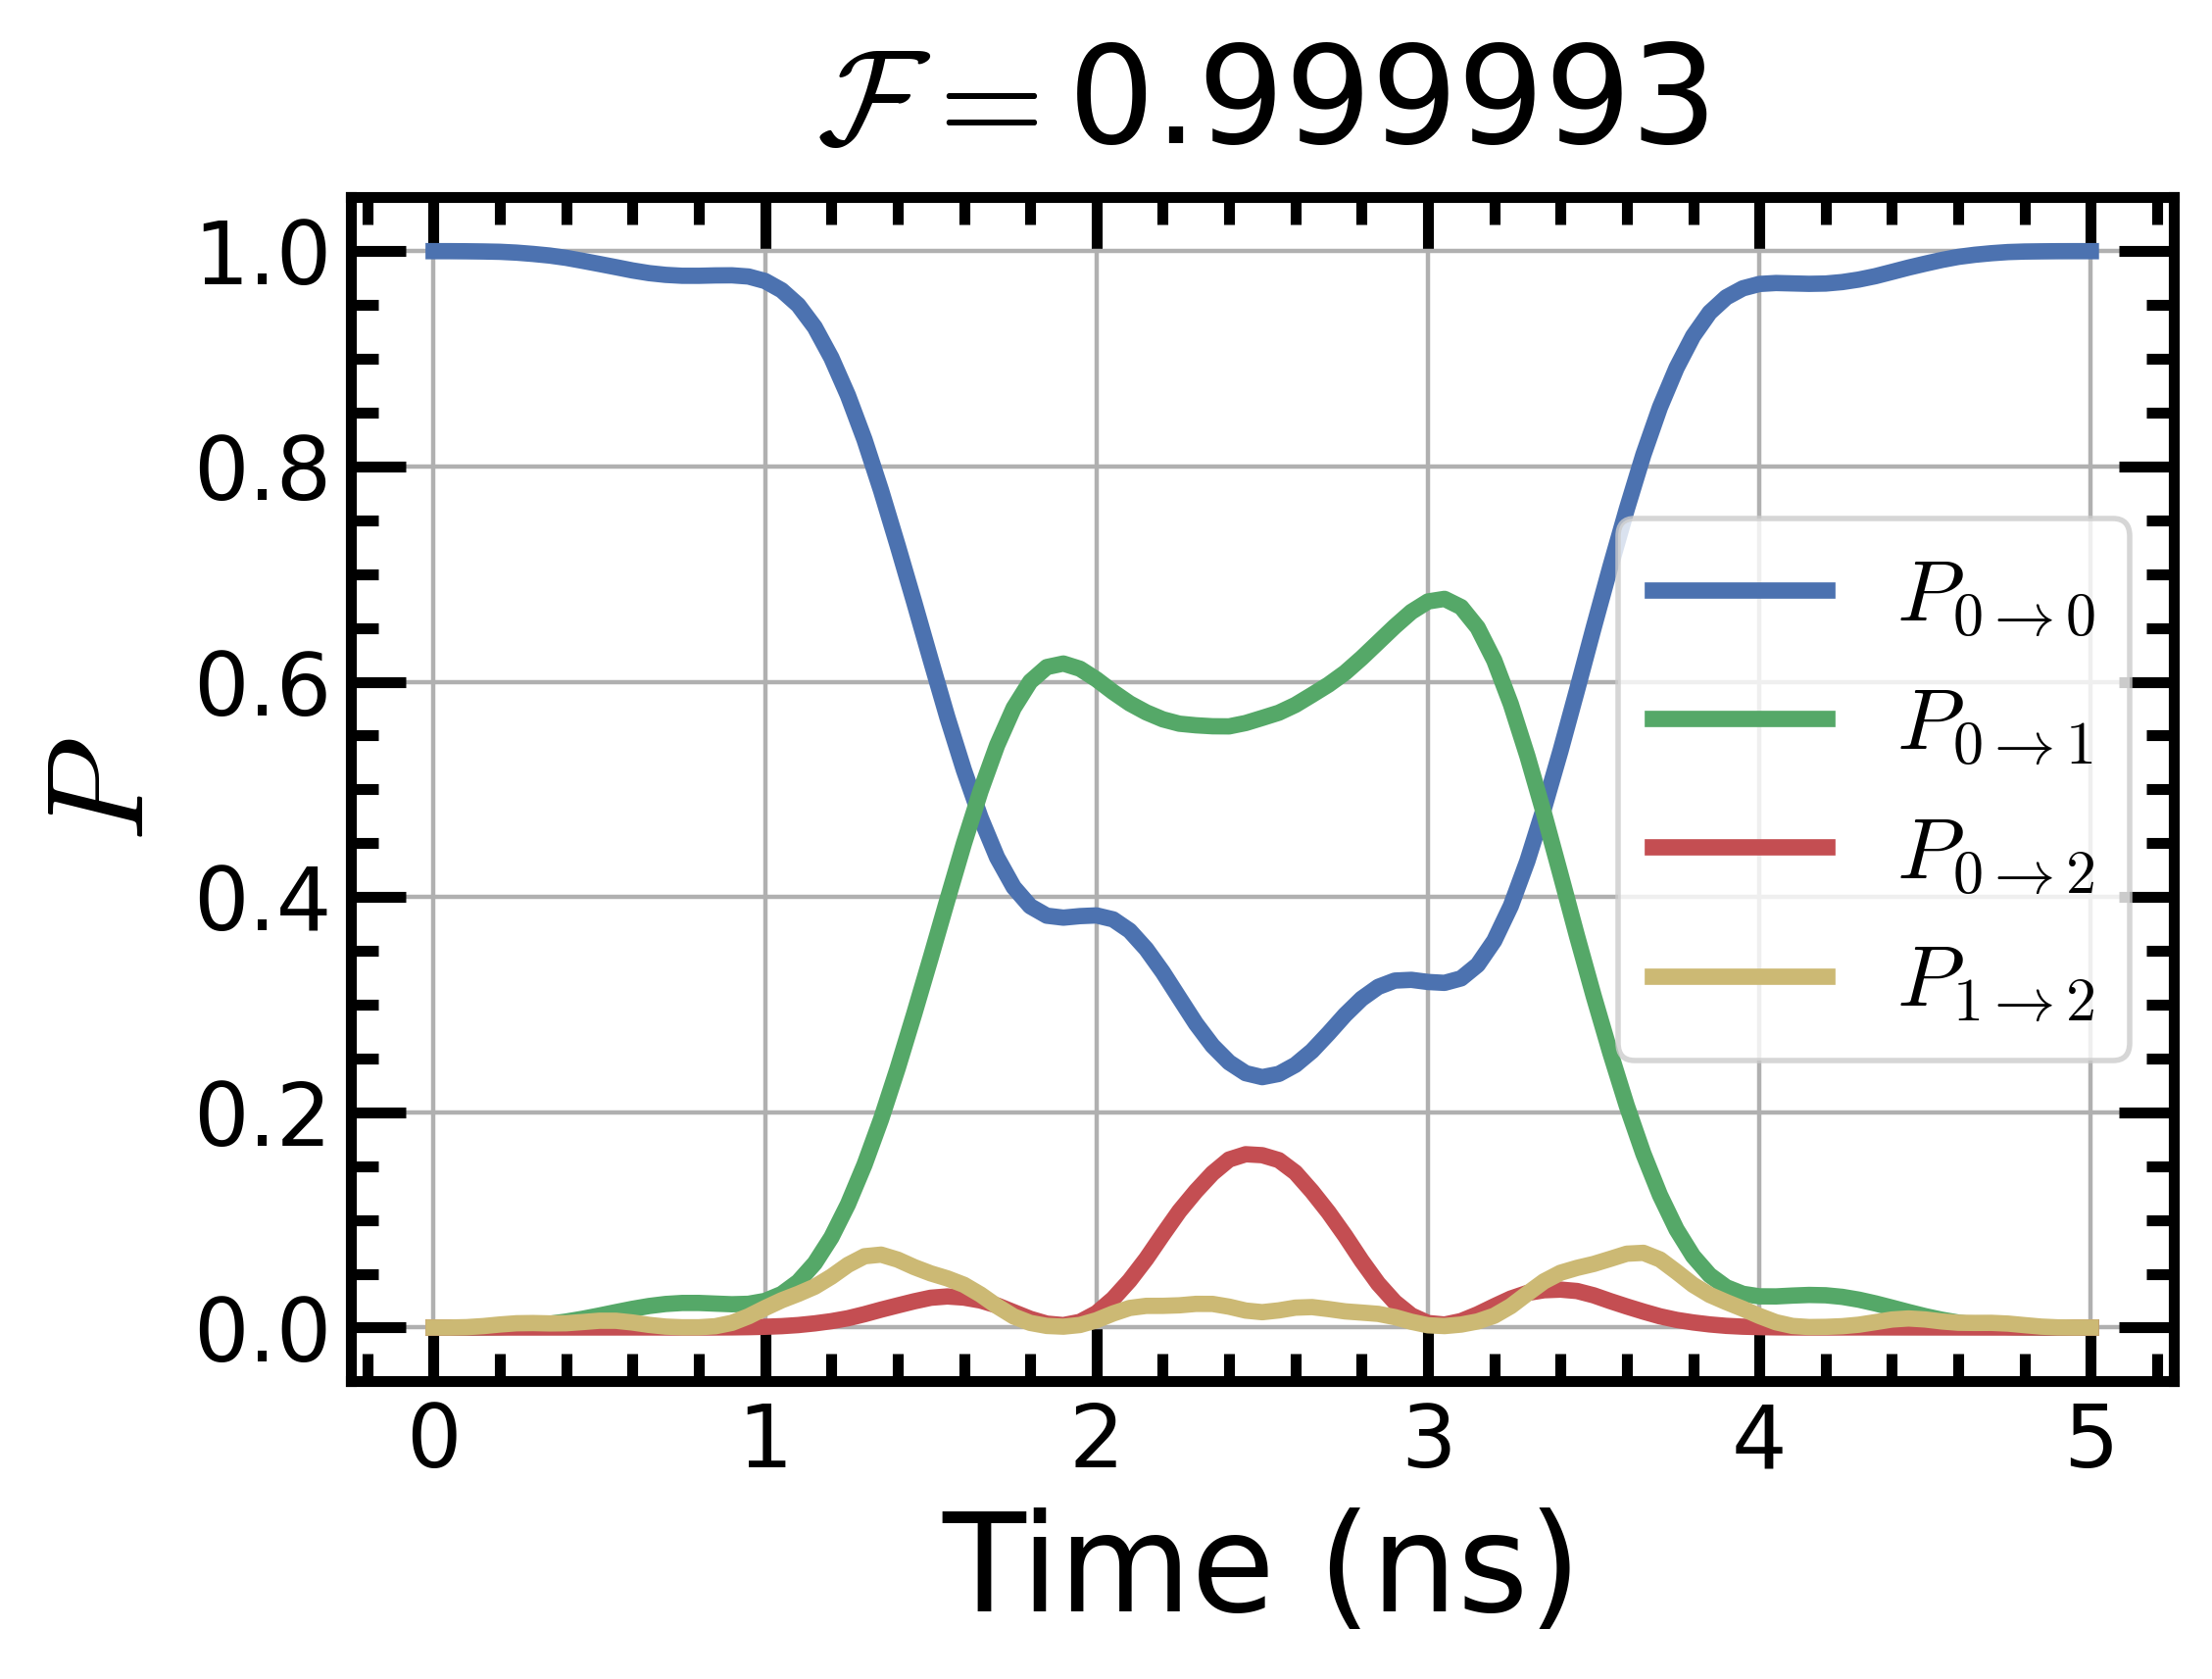

In [120]:
delta_omega_d=xopt.x[0]
drag_coeff = xopt.x[1]
omega_d = qubit.freq(0,1) + delta_omega_d
U_t = gates.evolution_operator_microwave(
        qubit.H(), H_drive, t_points=t_points, DRAG = drag, DRAG_coefficient = drag_coeff,
        T_gate=T_gate, shape=shape, sigma=sigma, omega_d=omega_d)

U_real = U_nothing[-1]*U_t[-1]
U_real = Qobj(U_real[0:2, 0:2])

op1 = U_real.dag() * U_real
op2 = U_real * U_ideal.dag()
fidel = (op1.tr() + (abs(op2.tr())) ** 2) / 6.0
print(1-fidel)

trans_prob_0 = gates.prob_transition(U_t, state_0, state_0)
trans_prob_1 = gates.prob_transition(U_t, state_0, state_1)
trans_prob_2 = gates.prob_transition(U_t, state_0, state_2)
trans_prob_3 = gates.prob_transition(U_t, state_1, state_2)
plt.plot(t_points, trans_prob_0, label=r'$P_{0\rightarrow 0}$')
plt.plot(t_points, trans_prob_1, label=r'$P_{0\rightarrow 1}$')
plt.plot(t_points, trans_prob_2, label=r'$P_{0\rightarrow 2}$')
plt.plot(t_points, trans_prob_3, color = 'C4', label=r'$P_{1\rightarrow 2}$')
plt.xlabel('Time (ns)')
plt.ylabel(r'$P$')
plt.legend()
plt.grid()
plt.title(r'$\mathcal{F}=$'+str(np.round(fidel,6)))

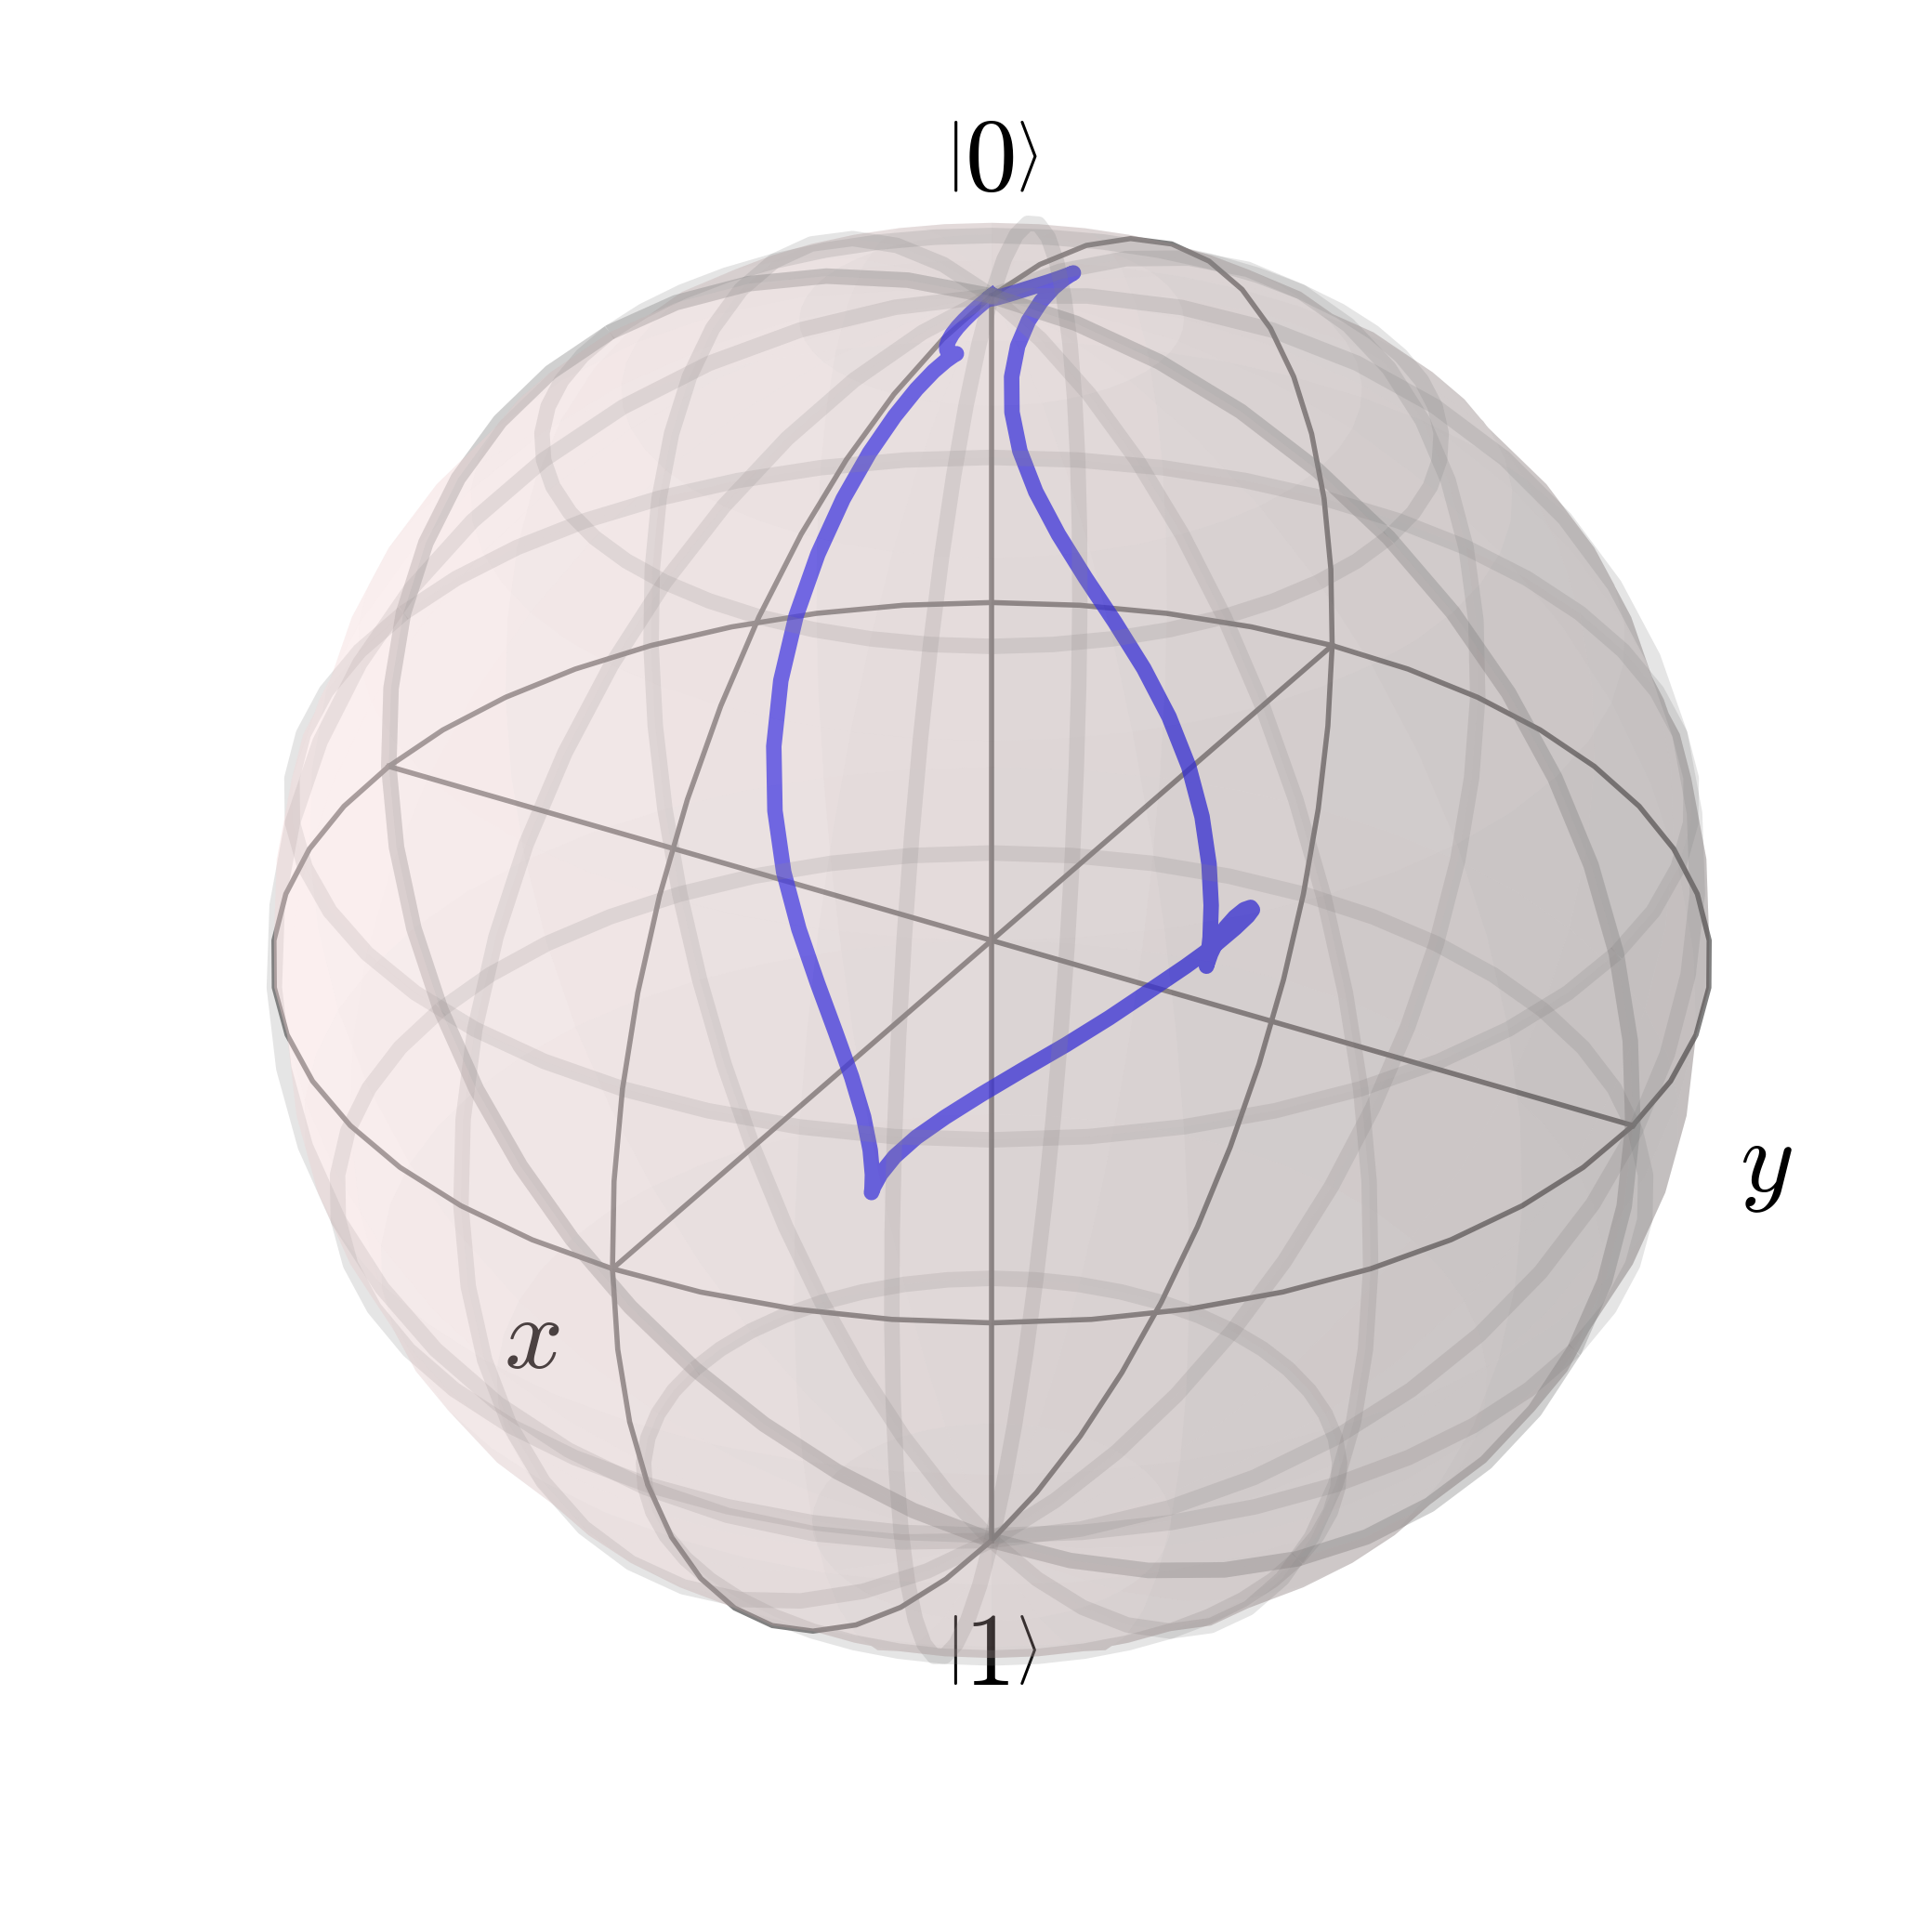

In [121]:
# Trajectory on Bloch sphere
state_evol = U_nothing * U_t * state_0

sz = np.real(expect(state_0*state_0.dag() - state_1*state_1.dag(),state_evol))
sx = np.real(expect(state_0*state_1.dag()+state_0*state_1.dag(),state_evol))
sy = np.real(expect(-1j*state_0*state_1.dag() + 1j*state_0*state_1.dag(),state_evol))

b = Bloch()
b.add_points([sx, sy, sz], meth ='l')
b.make_sphere()

0.5000901743577423


Text(0.5, 1.0, '$\\mathcal{F}=$0.50009')

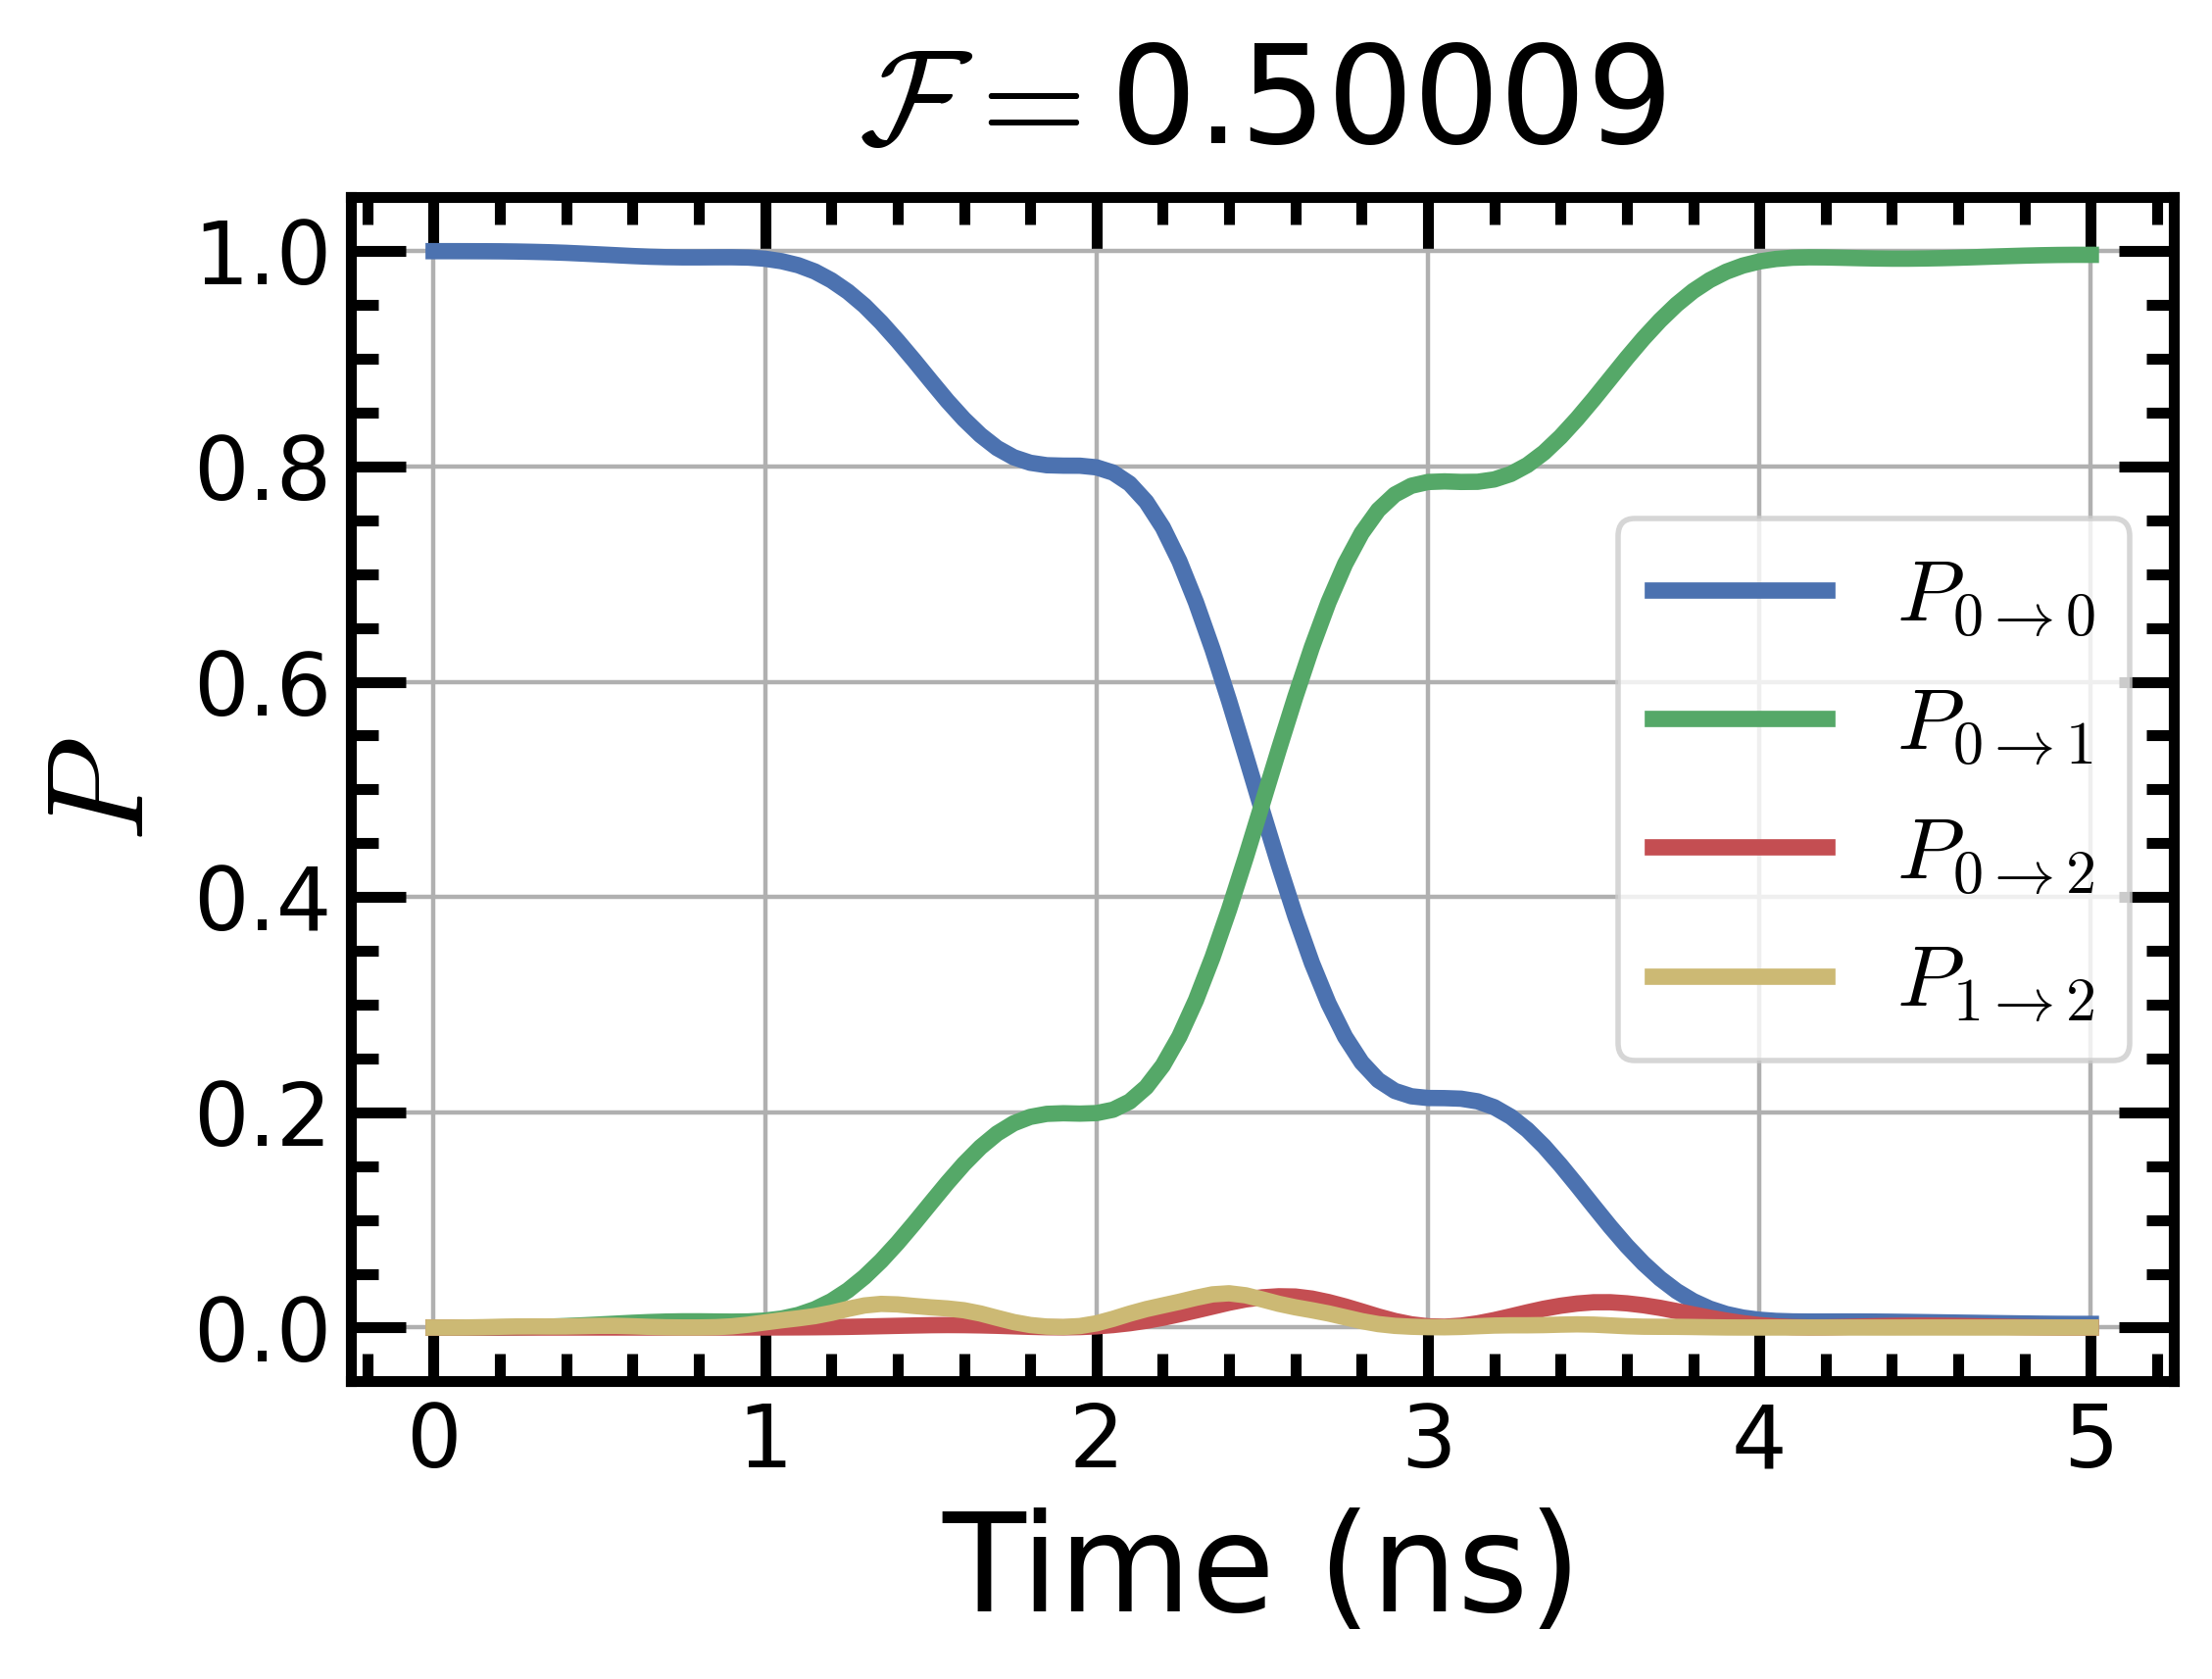

In [98]:
# Now check with pi-pulses using 2pi-pulse optimal parameters
delta_omega_d=xopt.x[0]
drag_coeff = xopt.x[1]
# delta_omega_d=0
# drag_coeff = 0
drive_amplitude_factor = 0.5 #Giving pi pulse
omega_d = qubit.freq(0,1) + delta_omega_d
epsilon = drive_amplitude_factor/matr_el
H_drive = epsilon*(qubit.n())
H_dummy = 0*(qubit.n())

U_t = gates.evolution_operator_microwave(
        qubit.H(), H_drive, t_points=t_points, DRAG = drag, DRAG_coefficient = drag_coeff,
        T_gate=T_gate, shape=shape, sigma=sigma, omega_d=omega_d)
U_nothing = gates.evolution_operator_microwave(
        -qubit.H(), H_dummy, t_points=t_points, DRAG = drag, DRAG_coefficient = drag_coeff,
        T_gate=T_gate, shape=shape, sigma=sigma, omega_d=omega_d)

U_ideal = sigmay()
U_real = U_nothing[-1]*U_t[-1]
U_real = Qobj(U_real[0:2, 0:2])

op1 = U_real.dag() * U_real
op2 = U_real * U_ideal.dag()
fidel = (op1.tr() + (abs(op2.tr())) ** 2) / 6.0
print(fidel)


trans_prob_0 = gates.prob_transition(U_t, state_0, state_0)
trans_prob_1 = gates.prob_transition(U_t, state_0, state_1)
trans_prob_2 = gates.prob_transition(U_t, state_0, state_2)
trans_prob_3 = gates.prob_transition(U_t, state_1, state_2)
plt.plot(t_points, trans_prob_0, label=r'$P_{0\rightarrow 0}$')
plt.plot(t_points, trans_prob_1, label=r'$P_{0\rightarrow 1}$')
plt.plot(t_points, trans_prob_2, label=r'$P_{0\rightarrow 2}$')
plt.plot(t_points, trans_prob_3, color = 'C4', label=r'$P_{1\rightarrow 2}$')
plt.xlabel('Time (ns)')
plt.ylabel(r'$P$')
plt.legend()
plt.grid()
plt.title(r'$\mathcal{F}=$'+str(np.round(fidel,6)))

Optimizing a $2\pi$ pulse may not be what we actually want. Let's optimize the $\pi$ pulse instead

0.956770347282451


Text(0.5, 1.0, '$\\mathcal{F}=$0.95677')

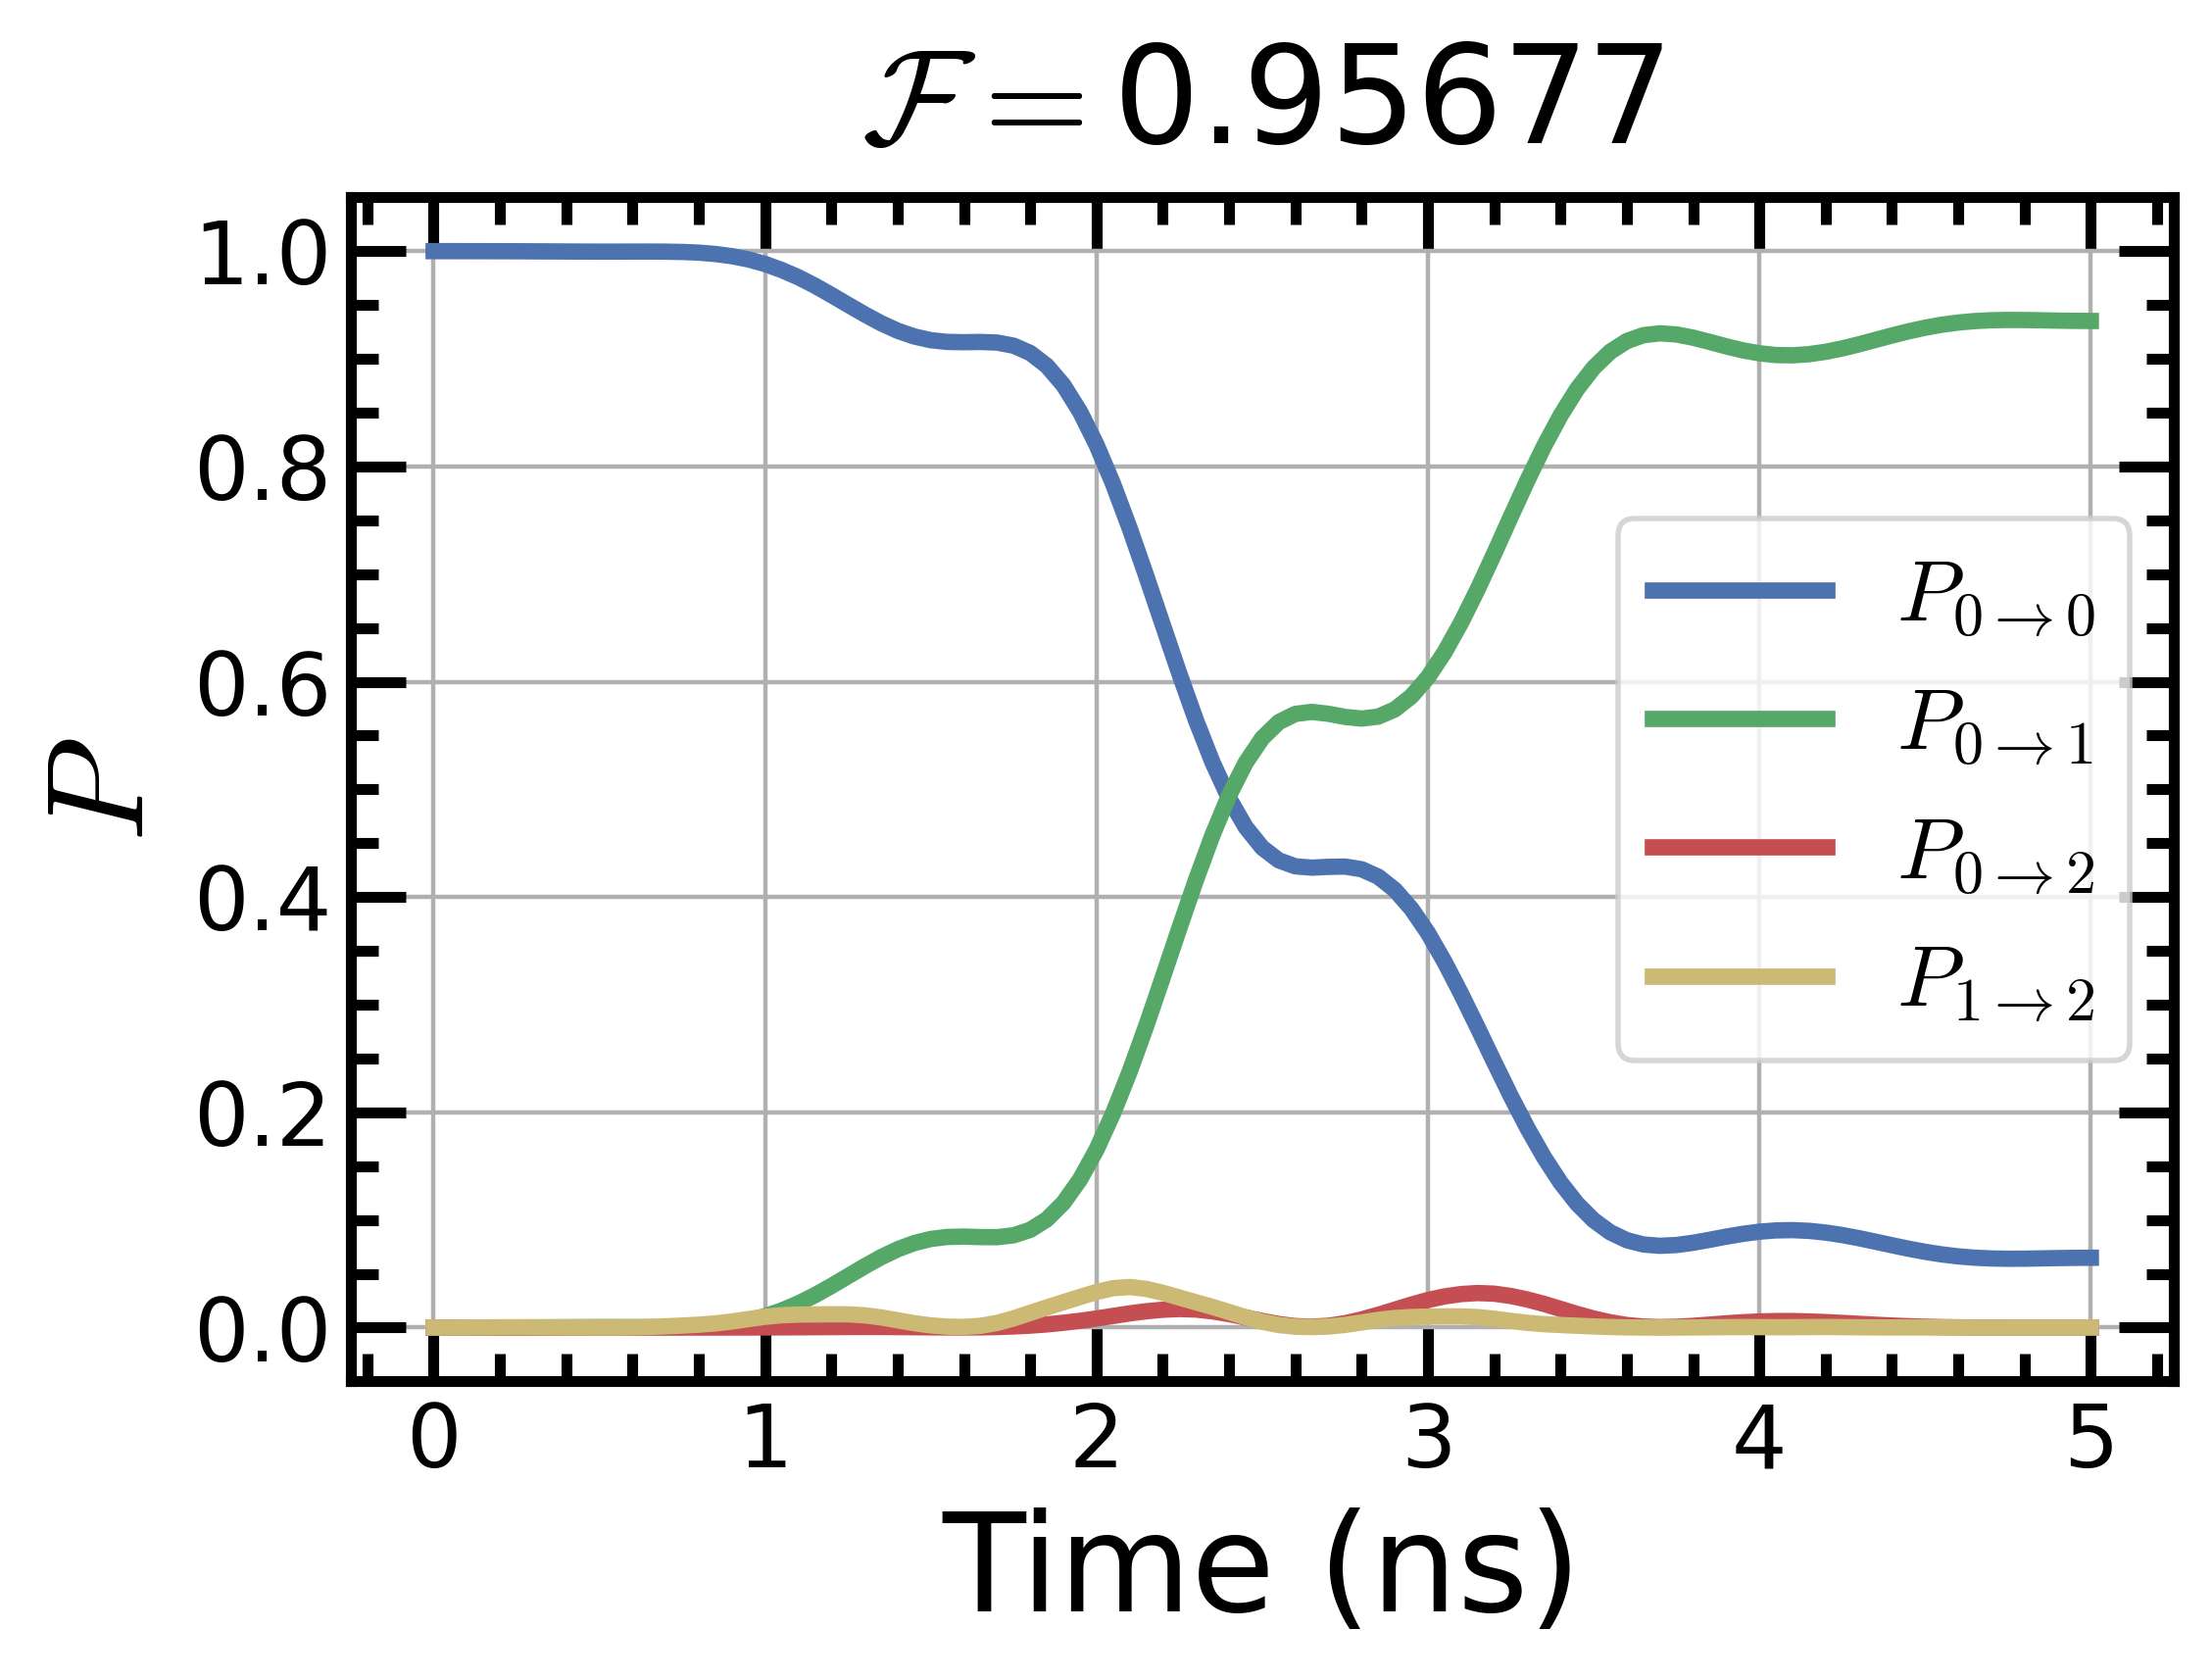

In [124]:
T_gate = 5 #ns
t_points = np.linspace(0, T_gate, 20 * int(T_gate) + 1)
drive_amplitude_factor = 0.5
drag_coeff = 0
delta_omega_d = 0
omega_d = qubit.freq(0,1) + delta_omega_d
epsilon = drive_amplitude_factor/matr_el
H_drive = epsilon*(qubit.n())
H_dummy = 0*(qubit.n())

U_t = gates.evolution_operator_microwave(
        qubit.H(), H_drive, t_points=t_points, DRAG = drag, DRAG_coefficient = drag_coeff,
        T_gate=T_gate, shape=shape, sigma=sigma, omega_d=omega_d)
U_nothing = gates.evolution_operator_microwave(
        -qubit.H(), H_dummy, t_points=t_points, DRAG = drag, DRAG_coefficient = drag_coeff,
        T_gate=T_gate, shape=shape, sigma=sigma, omega_d=omega_d)

U_ideal = sigmay()
U_real = U_nothing[-1]*U_t[-1]
U_real = Qobj(U_real[0:2, 0:2])

op1 = U_real.dag() * U_real
op2 = U_real * U_ideal.dag()
fidel = (op1.tr() + (abs(op2.tr())) ** 2) / 6.0
print(fidel)

trans_prob_0 = gates.prob_transition(U_t, state_0, state_0)
trans_prob_1 = gates.prob_transition(U_t, state_0, state_1)
trans_prob_2 = gates.prob_transition(U_t, state_0, state_2)
trans_prob_3 = gates.prob_transition(U_t, state_1, state_2)
plt.plot(t_points, trans_prob_0, label=r'$P_{0\rightarrow 0}$')
plt.plot(t_points, trans_prob_1, label=r'$P_{0\rightarrow 1}$')
plt.plot(t_points, trans_prob_2, label=r'$P_{0\rightarrow 2}$')
plt.plot(t_points, trans_prob_3, color = 'C4', label=r'$P_{1\rightarrow 2}$')
plt.xlabel('Time (ns)')
plt.ylabel(r'$P$')
plt.legend()
plt.grid()
plt.title(r'$\mathcal{F}=$'+str(np.round(fidel,6)))

In [125]:
t_points = np.linspace(0, T_gate, 2 * int(T_gate) + 1)
def infidelity_pi(x):
    delta_omega_d = x[0]
    drag_coeff = x[1]
    epsilon = drive_amplitude_factor/matr_el
    H_drive = epsilon*(qubit.n())
    omega_d = qubit.freq(0,1) + delta_omega_d
    U_t = gates.evolution_operator_microwave(
                qubit.H(), H_drive, t_points=t_points, DRAG = drag, DRAG_coefficient = drag_coeff,
                T_gate=T_gate, shape=shape, sigma=sigma, omega_d=omega_d)
    U_nothing = gates.evolution_operator_microwave(
        -qubit.H(), H_dummy, t_points=t_points, DRAG = drag, DRAG_coefficient = drag_coeff,
        T_gate=T_gate, shape=shape, sigma=sigma, omega_d=omega_d)
    U_real = U_nothing[-1]*U_t[-1]
    U_real = Qobj(U_real[0:2, 0:2])
    op1 = U_real.dag() * U_real
    op2 = U_real * U_ideal.dag()
    fidel = (op1.tr() + (abs(op2.tr())) ** 2) / 6.0
    return 1.0-fidel
x0 = [0,0]
xopt = minimize(infidelity_pi, x0=x0, method ='Powell', tol = 1e-6)
print (xopt.x)

[ 9.24174824e-05 -2.50330050e-01]


Text(0.5, 1.0, '$\\mathcal{F}=$0.999841')

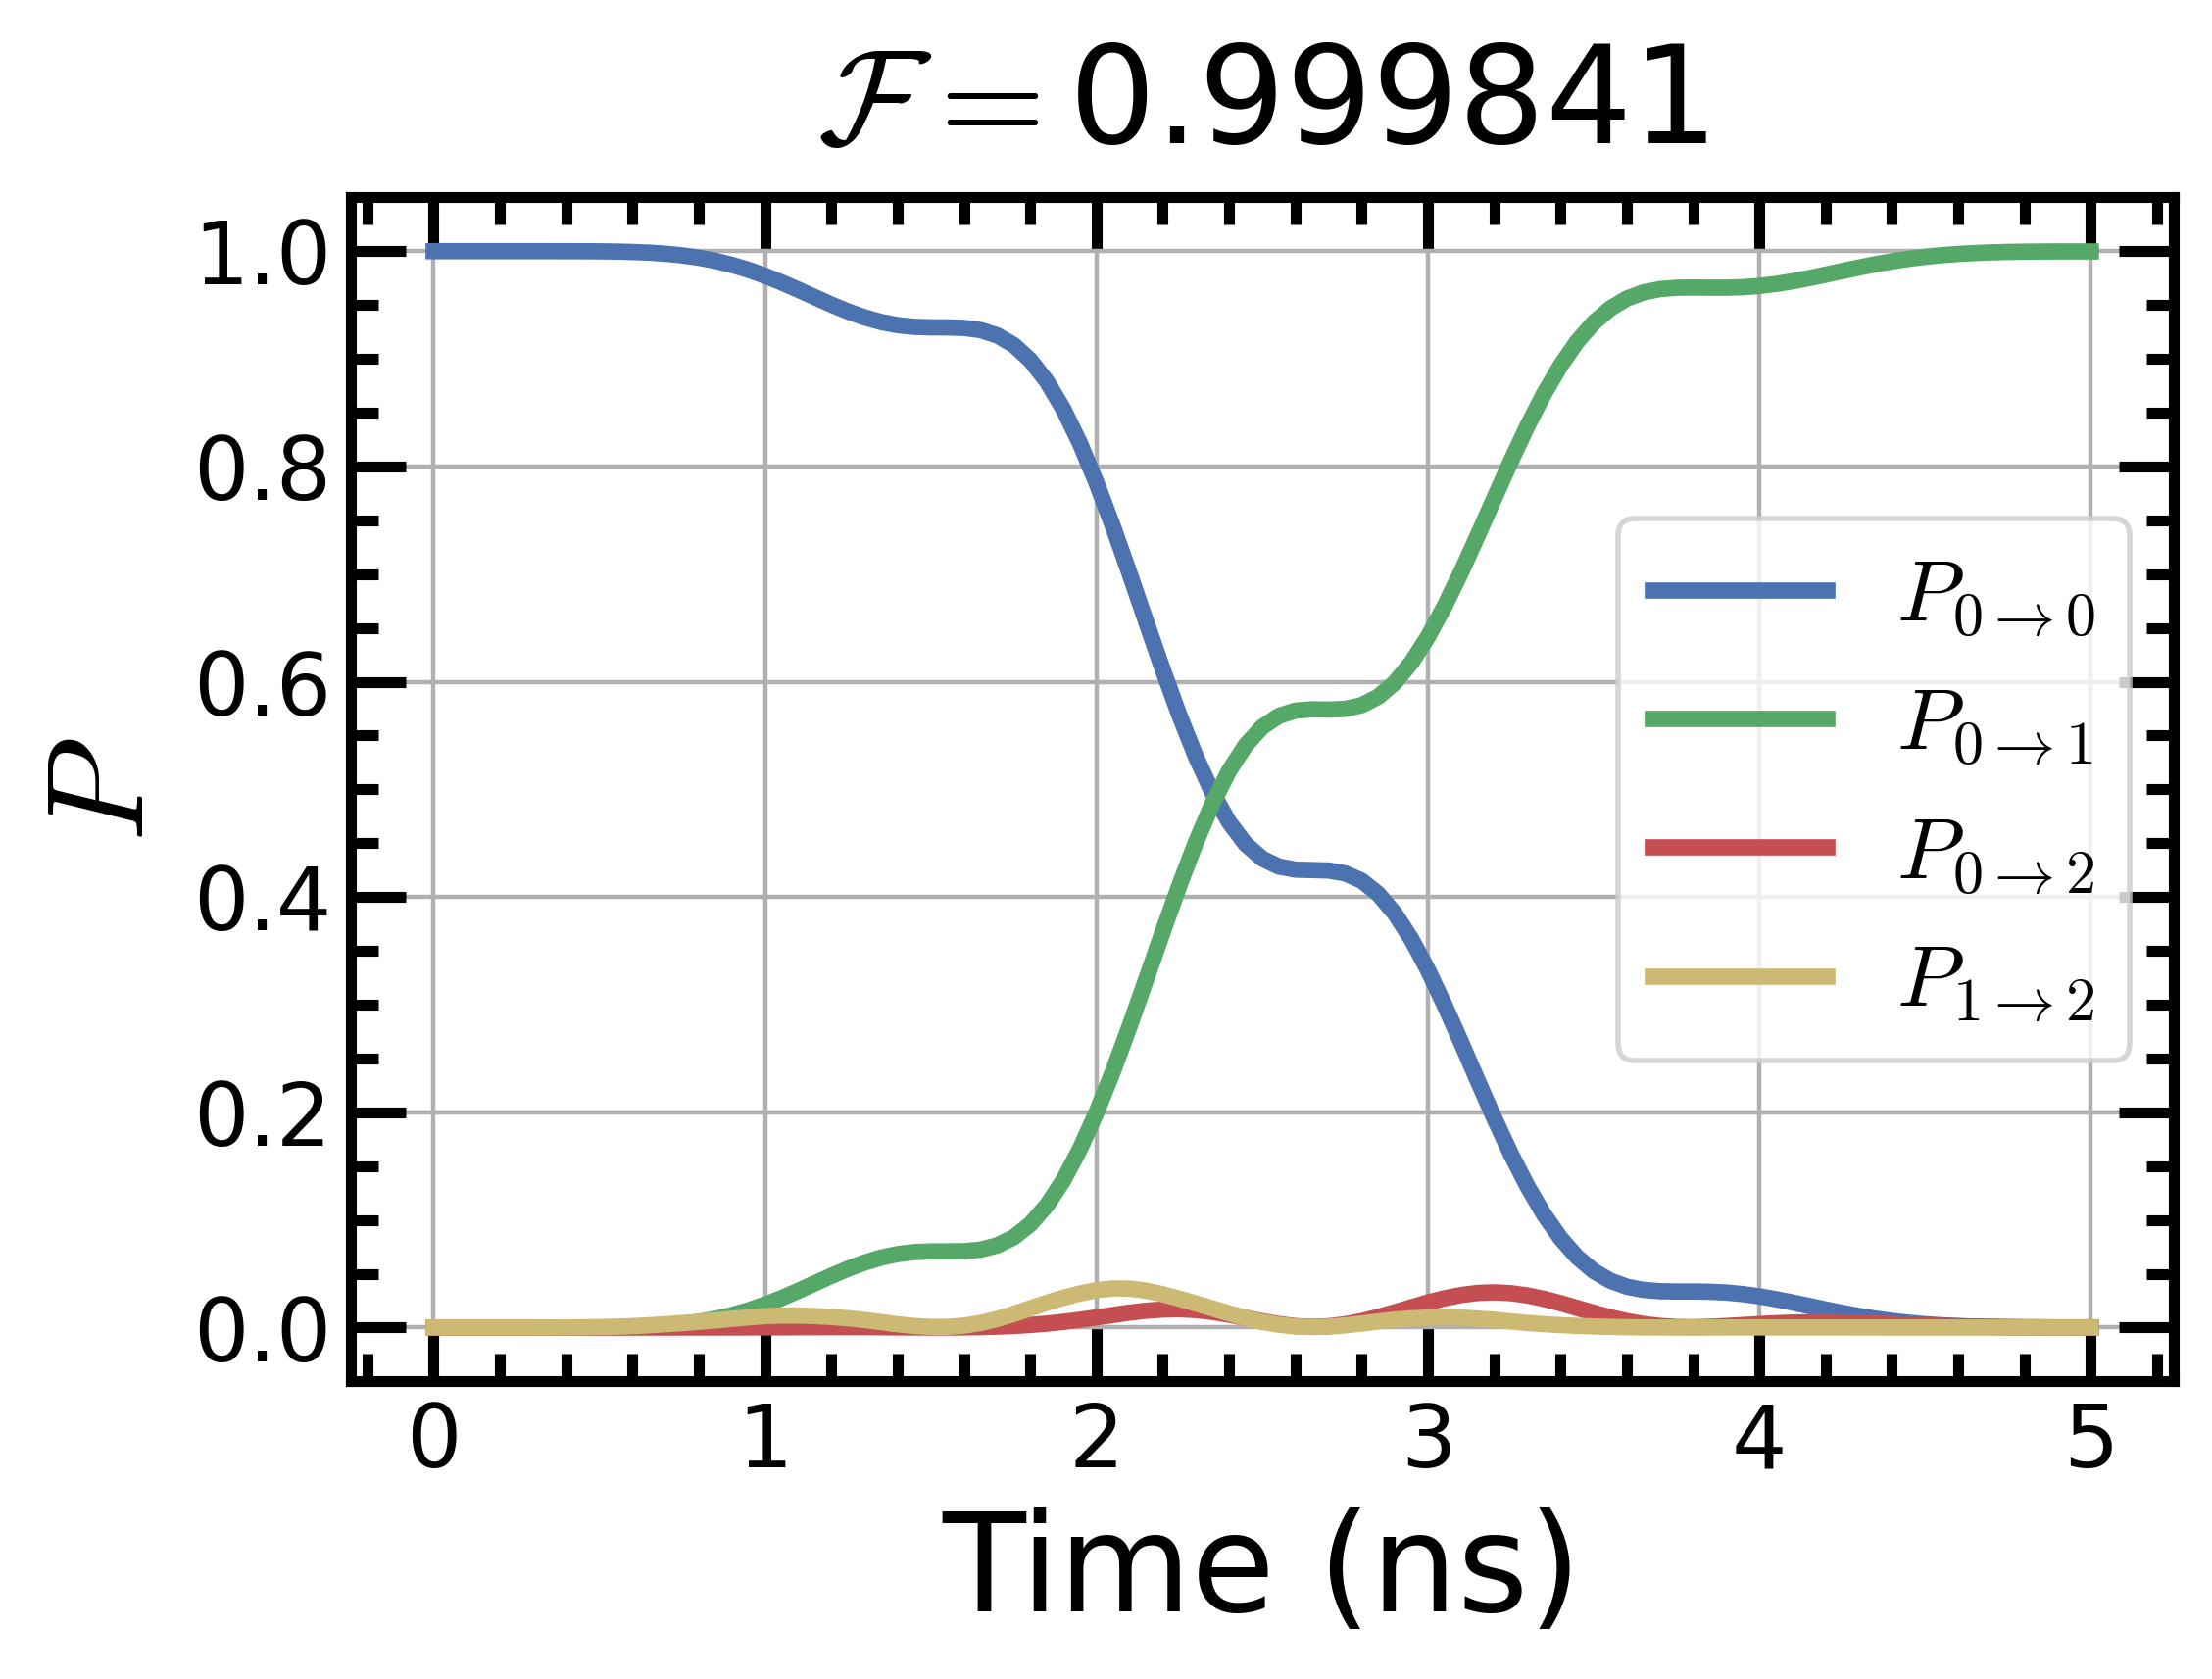

In [126]:
delta_omega_d, drag_coeff = xopt.x
epsilon = drive_amplitude_factor/matr_el
H_drive = epsilon*(qubit.n())
H_dummy = 0*(qubit.n())
omega_d = qubit.freq(0,1) + delta_omega_d
t_points = np.linspace(0, T_gate, 20 * int(T_gate) + 1)

U_t = gates.evolution_operator_microwave(
        qubit.H(), H_drive, t_points=t_points, DRAG = drag, DRAG_coefficient = drag_coeff,
        T_gate=T_gate, shape=shape, sigma=sigma, omega_d=omega_d)
U_nothing = gates.evolution_operator_microwave(
        -qubit.H(), H_dummy, t_points=t_points, DRAG = drag, DRAG_coefficient = drag_coeff,
        T_gate=T_gate, shape=shape, sigma=sigma, omega_d=omega_d)

U_ideal = sigmay()
U_real = U_nothing[-1]*U_t[-1]
U_real = Qobj(U_real[0:2, 0:2])

op1 = U_real.dag() * U_real
op2 = U_real * U_ideal.dag()
fidel = (op1.tr() + (abs(op2.tr())) ** 2) / 6.0

trans_prob_0 = gates.prob_transition(U_nothing*U_t, state_0, state_0)
trans_prob_1 = gates.prob_transition(U_nothing*U_t, state_0, state_1)
trans_prob_2 = gates.prob_transition(U_nothing*U_t, state_0, state_2)
trans_prob_3 = gates.prob_transition(U_nothing*U_t, state_1, state_2)
plt.plot(t_points, trans_prob_0, label=r'$P_{0\rightarrow 0}$')
plt.plot(t_points, trans_prob_1, label=r'$P_{0\rightarrow 1}$')
plt.plot(t_points, trans_prob_2, label=r'$P_{0\rightarrow 2}$')
plt.plot(t_points, trans_prob_3, color = 'C4', label=r'$P_{1\rightarrow 2}$')
plt.xlabel('Time (ns)')
plt.ylabel(r'$P$')
plt.legend()
plt.grid()
plt.title(r'$\mathcal{F}=$'+str(np.round(fidel,6)))

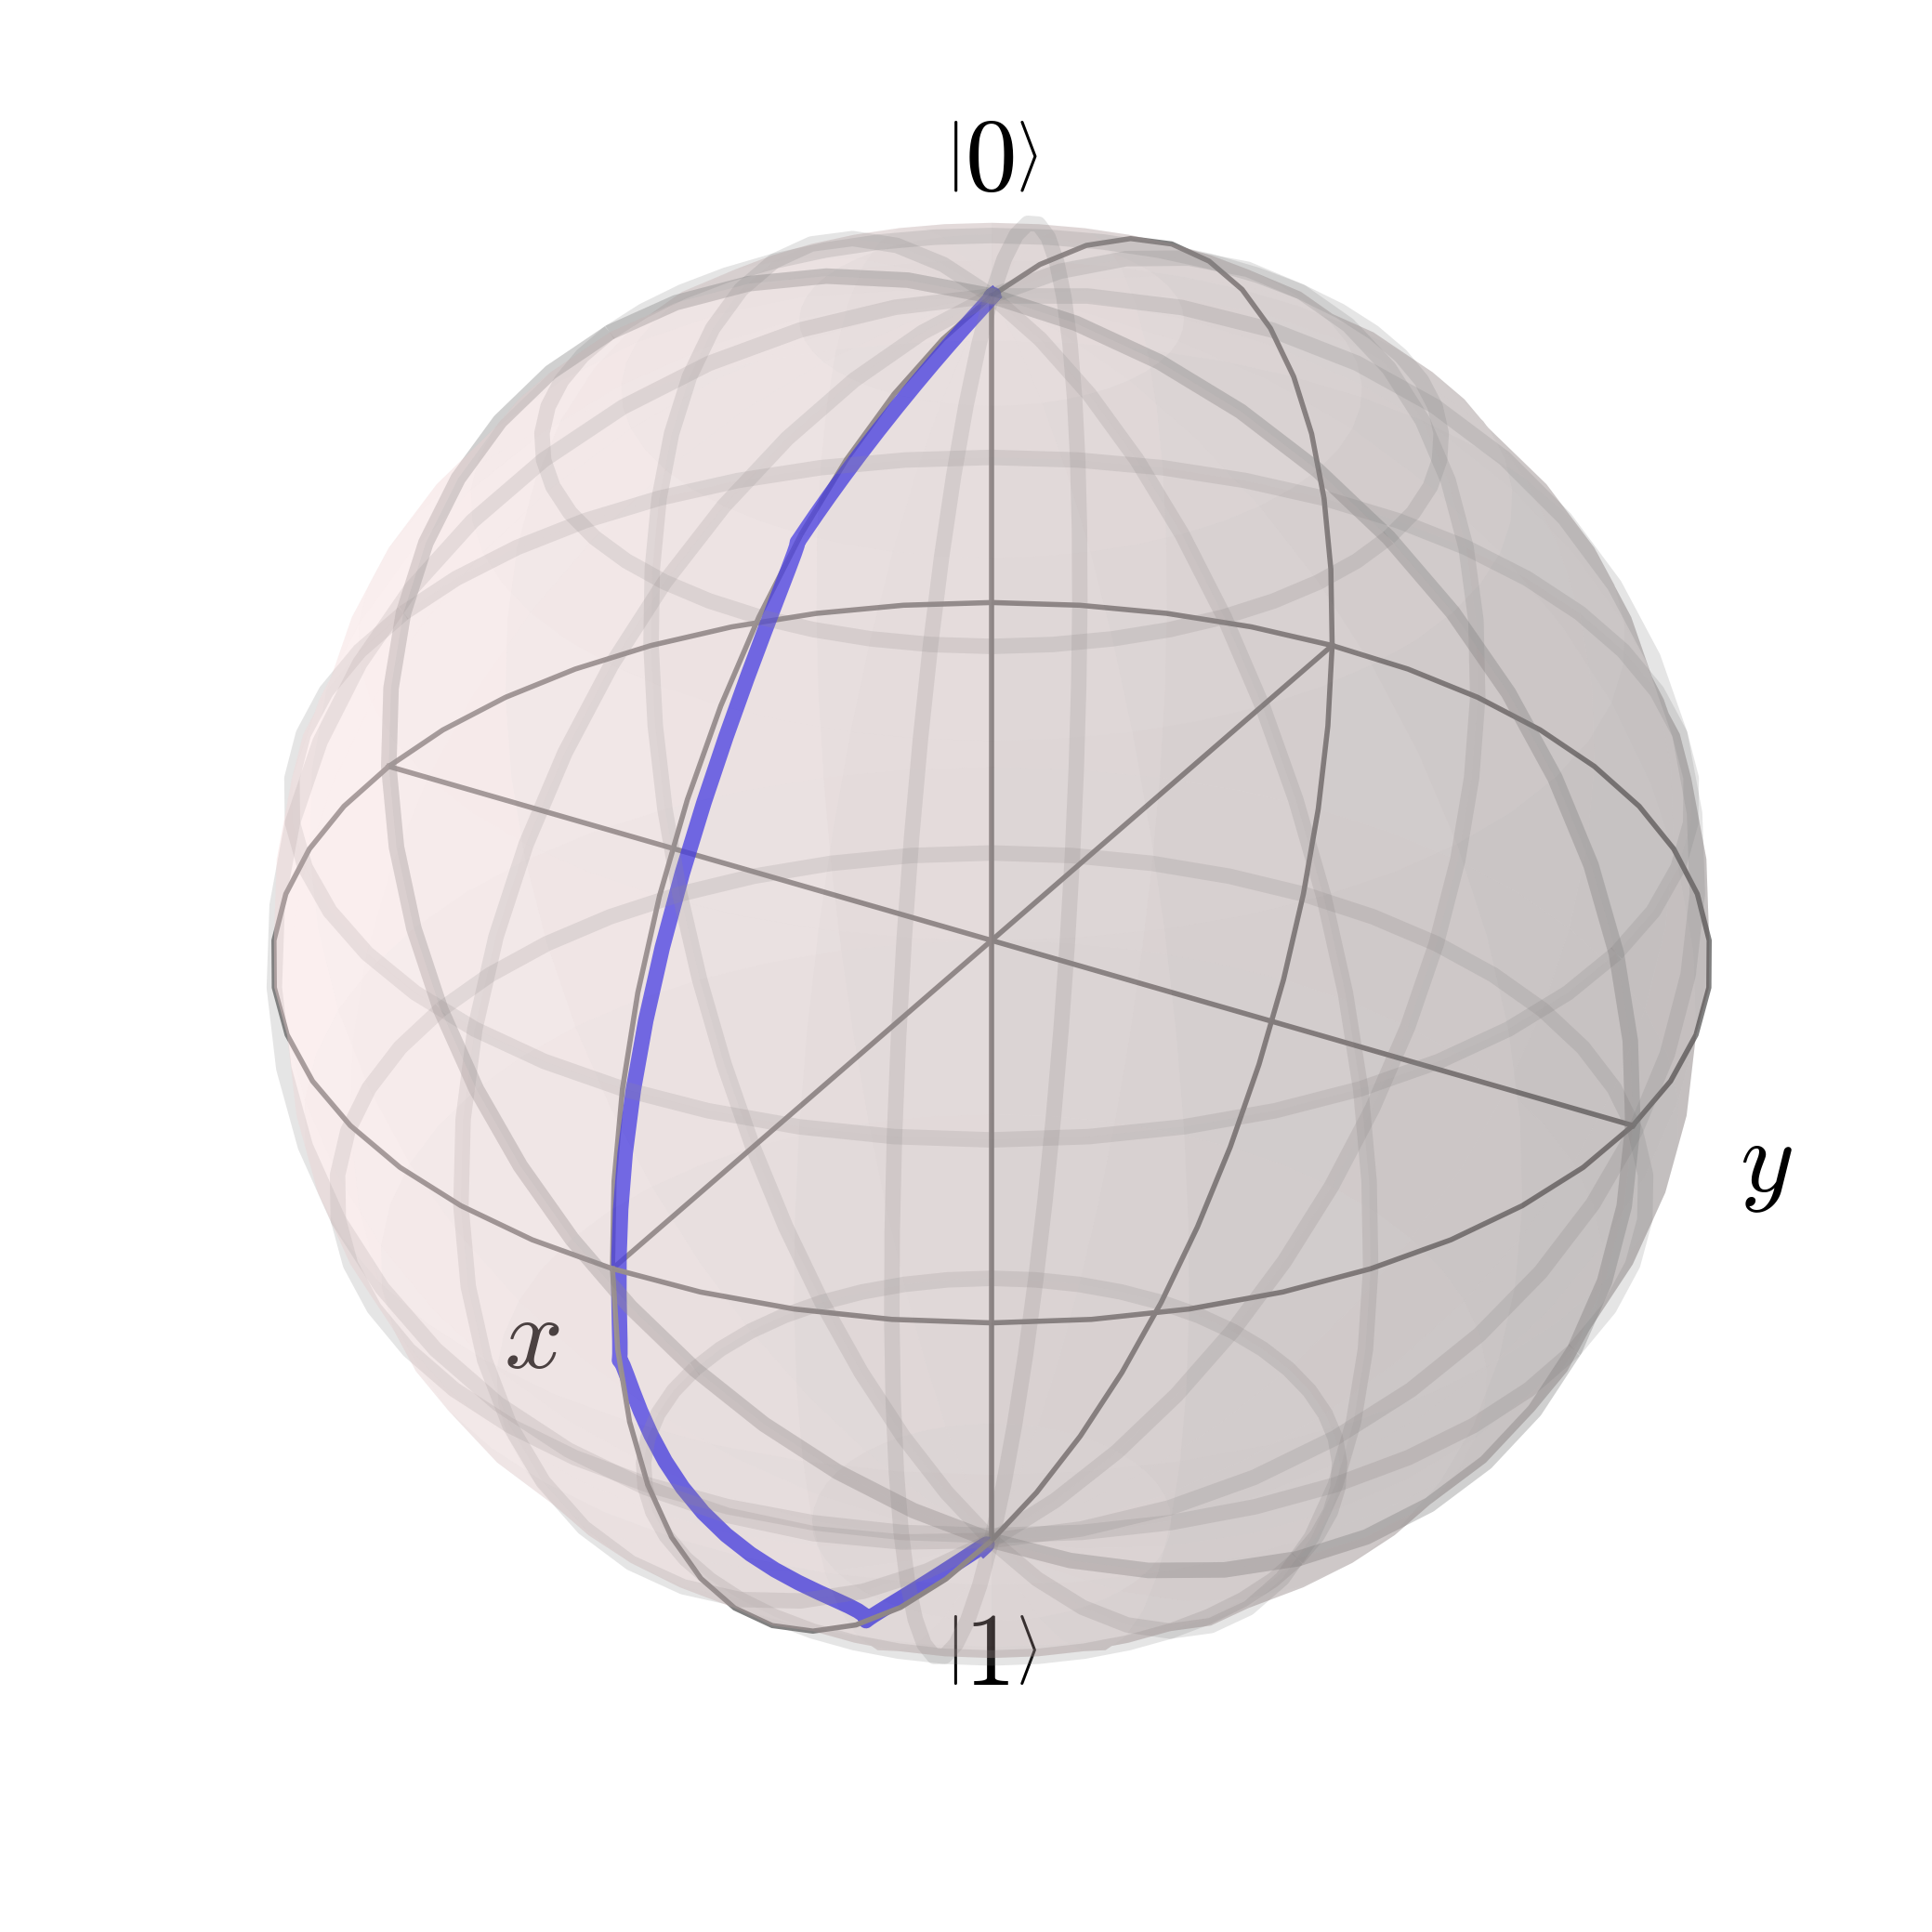

In [127]:
# Trajectory on Bloch sphere
state_evol = U_nothing * U_t * state_0

sz = np.real(expect(state_0*state_0.dag() - state_1*state_1.dag(),state_evol))
sx = np.real(expect(state_0*state_1.dag()+state_0*state_1.dag(),state_evol))
sy = np.real(expect(-1j*state_0*state_1.dag() + 1j*state_0*state_1.dag(),state_evol))

b = Bloch()
b.add_points([sx, sy, sz], meth ='l')
b.make_sphere()

### Check that $\pi/2$ pulses also work

<ipython-input-129-47c9630e3632>:17: DeprecationWarning: Importing functions/classes of the qip submodule directly from the namespace qutip is deprecated. Please import them from the submodule instead, e.g.
from qutip.qip.operations import cnot
from qutip.qip.circuit import QubitCircuit

  U_ideal = ry(np.pi/2.0)


Text(0.5, 1.0, '$\\mathcal{F}=$0.999973')

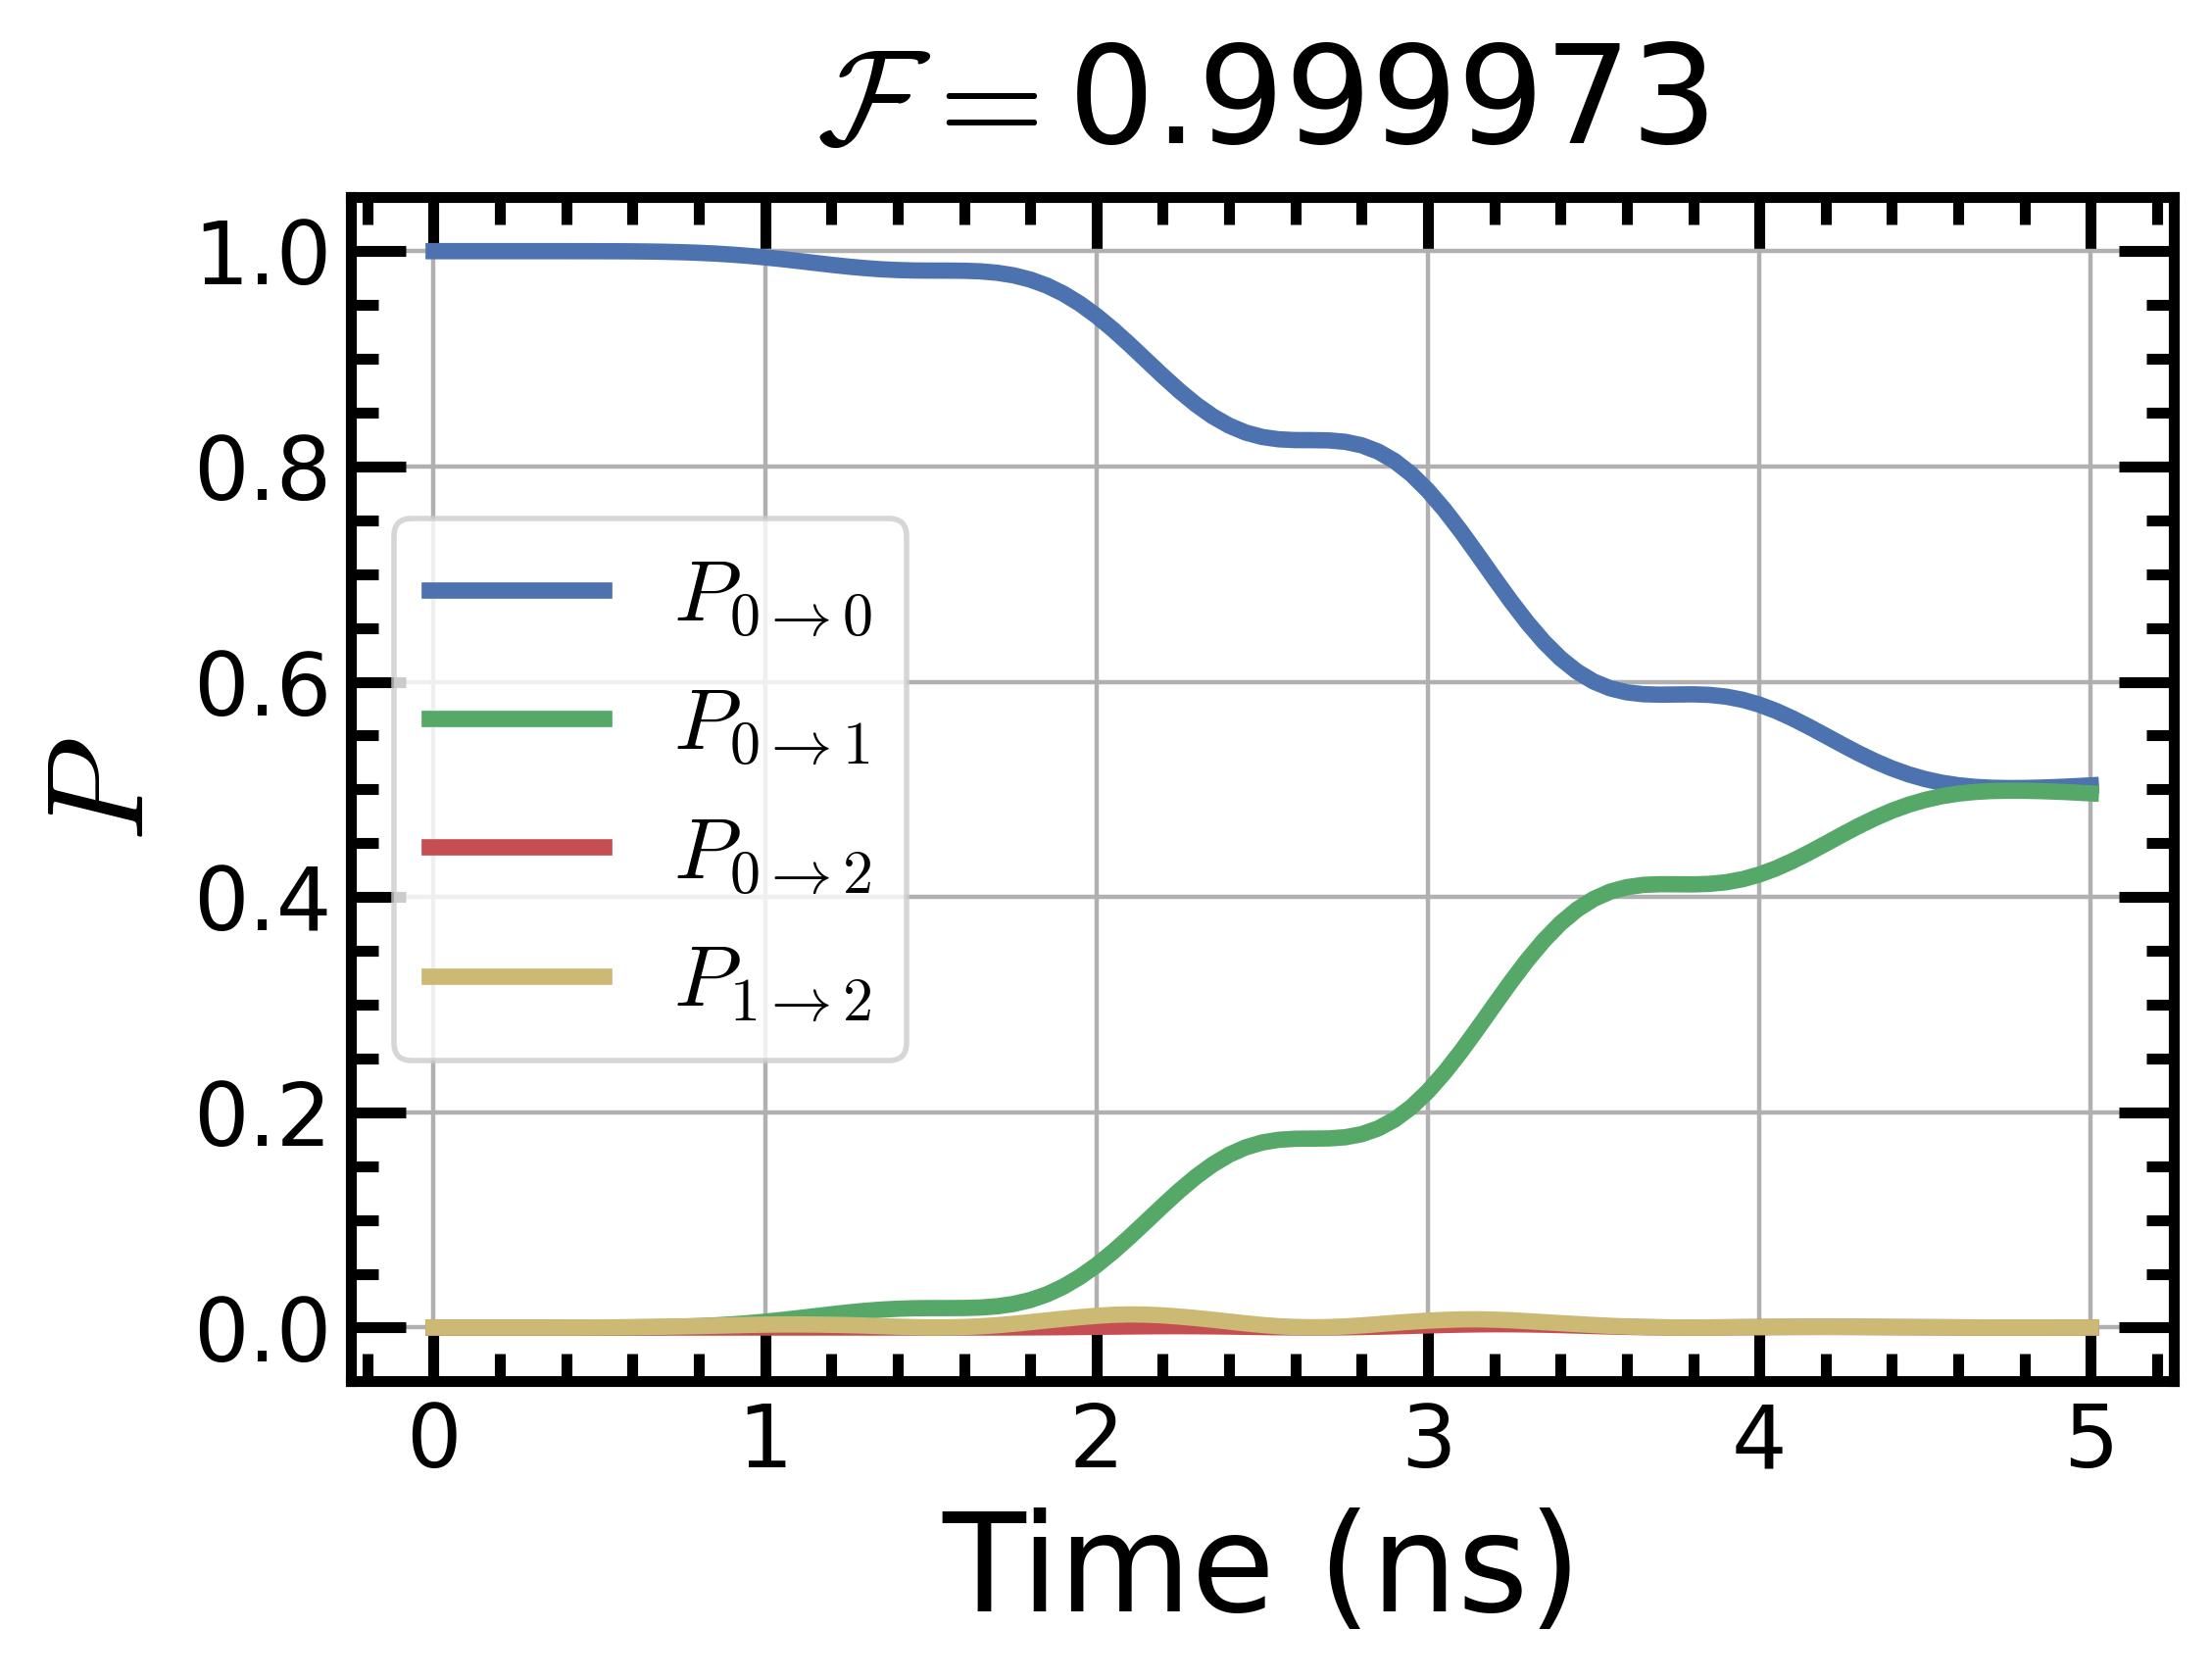

In [129]:
## Check pi/2 pulses
delta_omega_d, drag_coeff = xopt.x
drive_amplitude_factor = 0.25
epsilon = drive_amplitude_factor/matr_el
H_drive = epsilon*(qubit.n())
H_dummy = 0*(qubit.n())
omega_d = qubit.freq(0,1) + delta_omega_d
t_points = np.linspace(0, T_gate, 20 * int(T_gate) + 1)

U_t = gates.evolution_operator_microwave(
        qubit.H(), H_drive, t_points=t_points, DRAG = drag, DRAG_coefficient = drag_coeff,
        T_gate=T_gate, shape=shape, sigma=sigma, omega_d=omega_d)
U_nothing = gates.evolution_operator_microwave(
        -qubit.H(), H_dummy, t_points=t_points, DRAG = drag, DRAG_coefficient = drag_coeff,
        T_gate=T_gate, shape=shape, sigma=sigma, omega_d=omega_d)

U_ideal = ry(np.pi/2.0)
U_real = U_nothing[-1]*U_t[-1]
U_real = Qobj(U_real[0:2, 0:2])

op1 = U_real.dag() * U_real
op2 = U_real * U_ideal.dag()
fidel = (op1.tr() + (abs(op2.tr())) ** 2) / 6.0

trans_prob_0 = gates.prob_transition(U_nothing*U_t, state_0, state_0)
trans_prob_1 = gates.prob_transition(U_nothing*U_t, state_0, state_1)
trans_prob_2 = gates.prob_transition(U_nothing*U_t, state_0, state_2)
trans_prob_3 = gates.prob_transition(U_nothing*U_t, state_1, state_2)
plt.plot(t_points, trans_prob_0, label=r'$P_{0\rightarrow 0}$')
plt.plot(t_points, trans_prob_1, label=r'$P_{0\rightarrow 1}$')
plt.plot(t_points, trans_prob_2, label=r'$P_{0\rightarrow 2}$')
plt.plot(t_points, trans_prob_3, color = 'C4', label=r'$P_{1\rightarrow 2}$')
plt.xlabel('Time (ns)')
plt.ylabel(r'$P$')
plt.legend()
plt.grid()
plt.title(r'$\mathcal{F}=$'+str(np.round(fidel,6)))

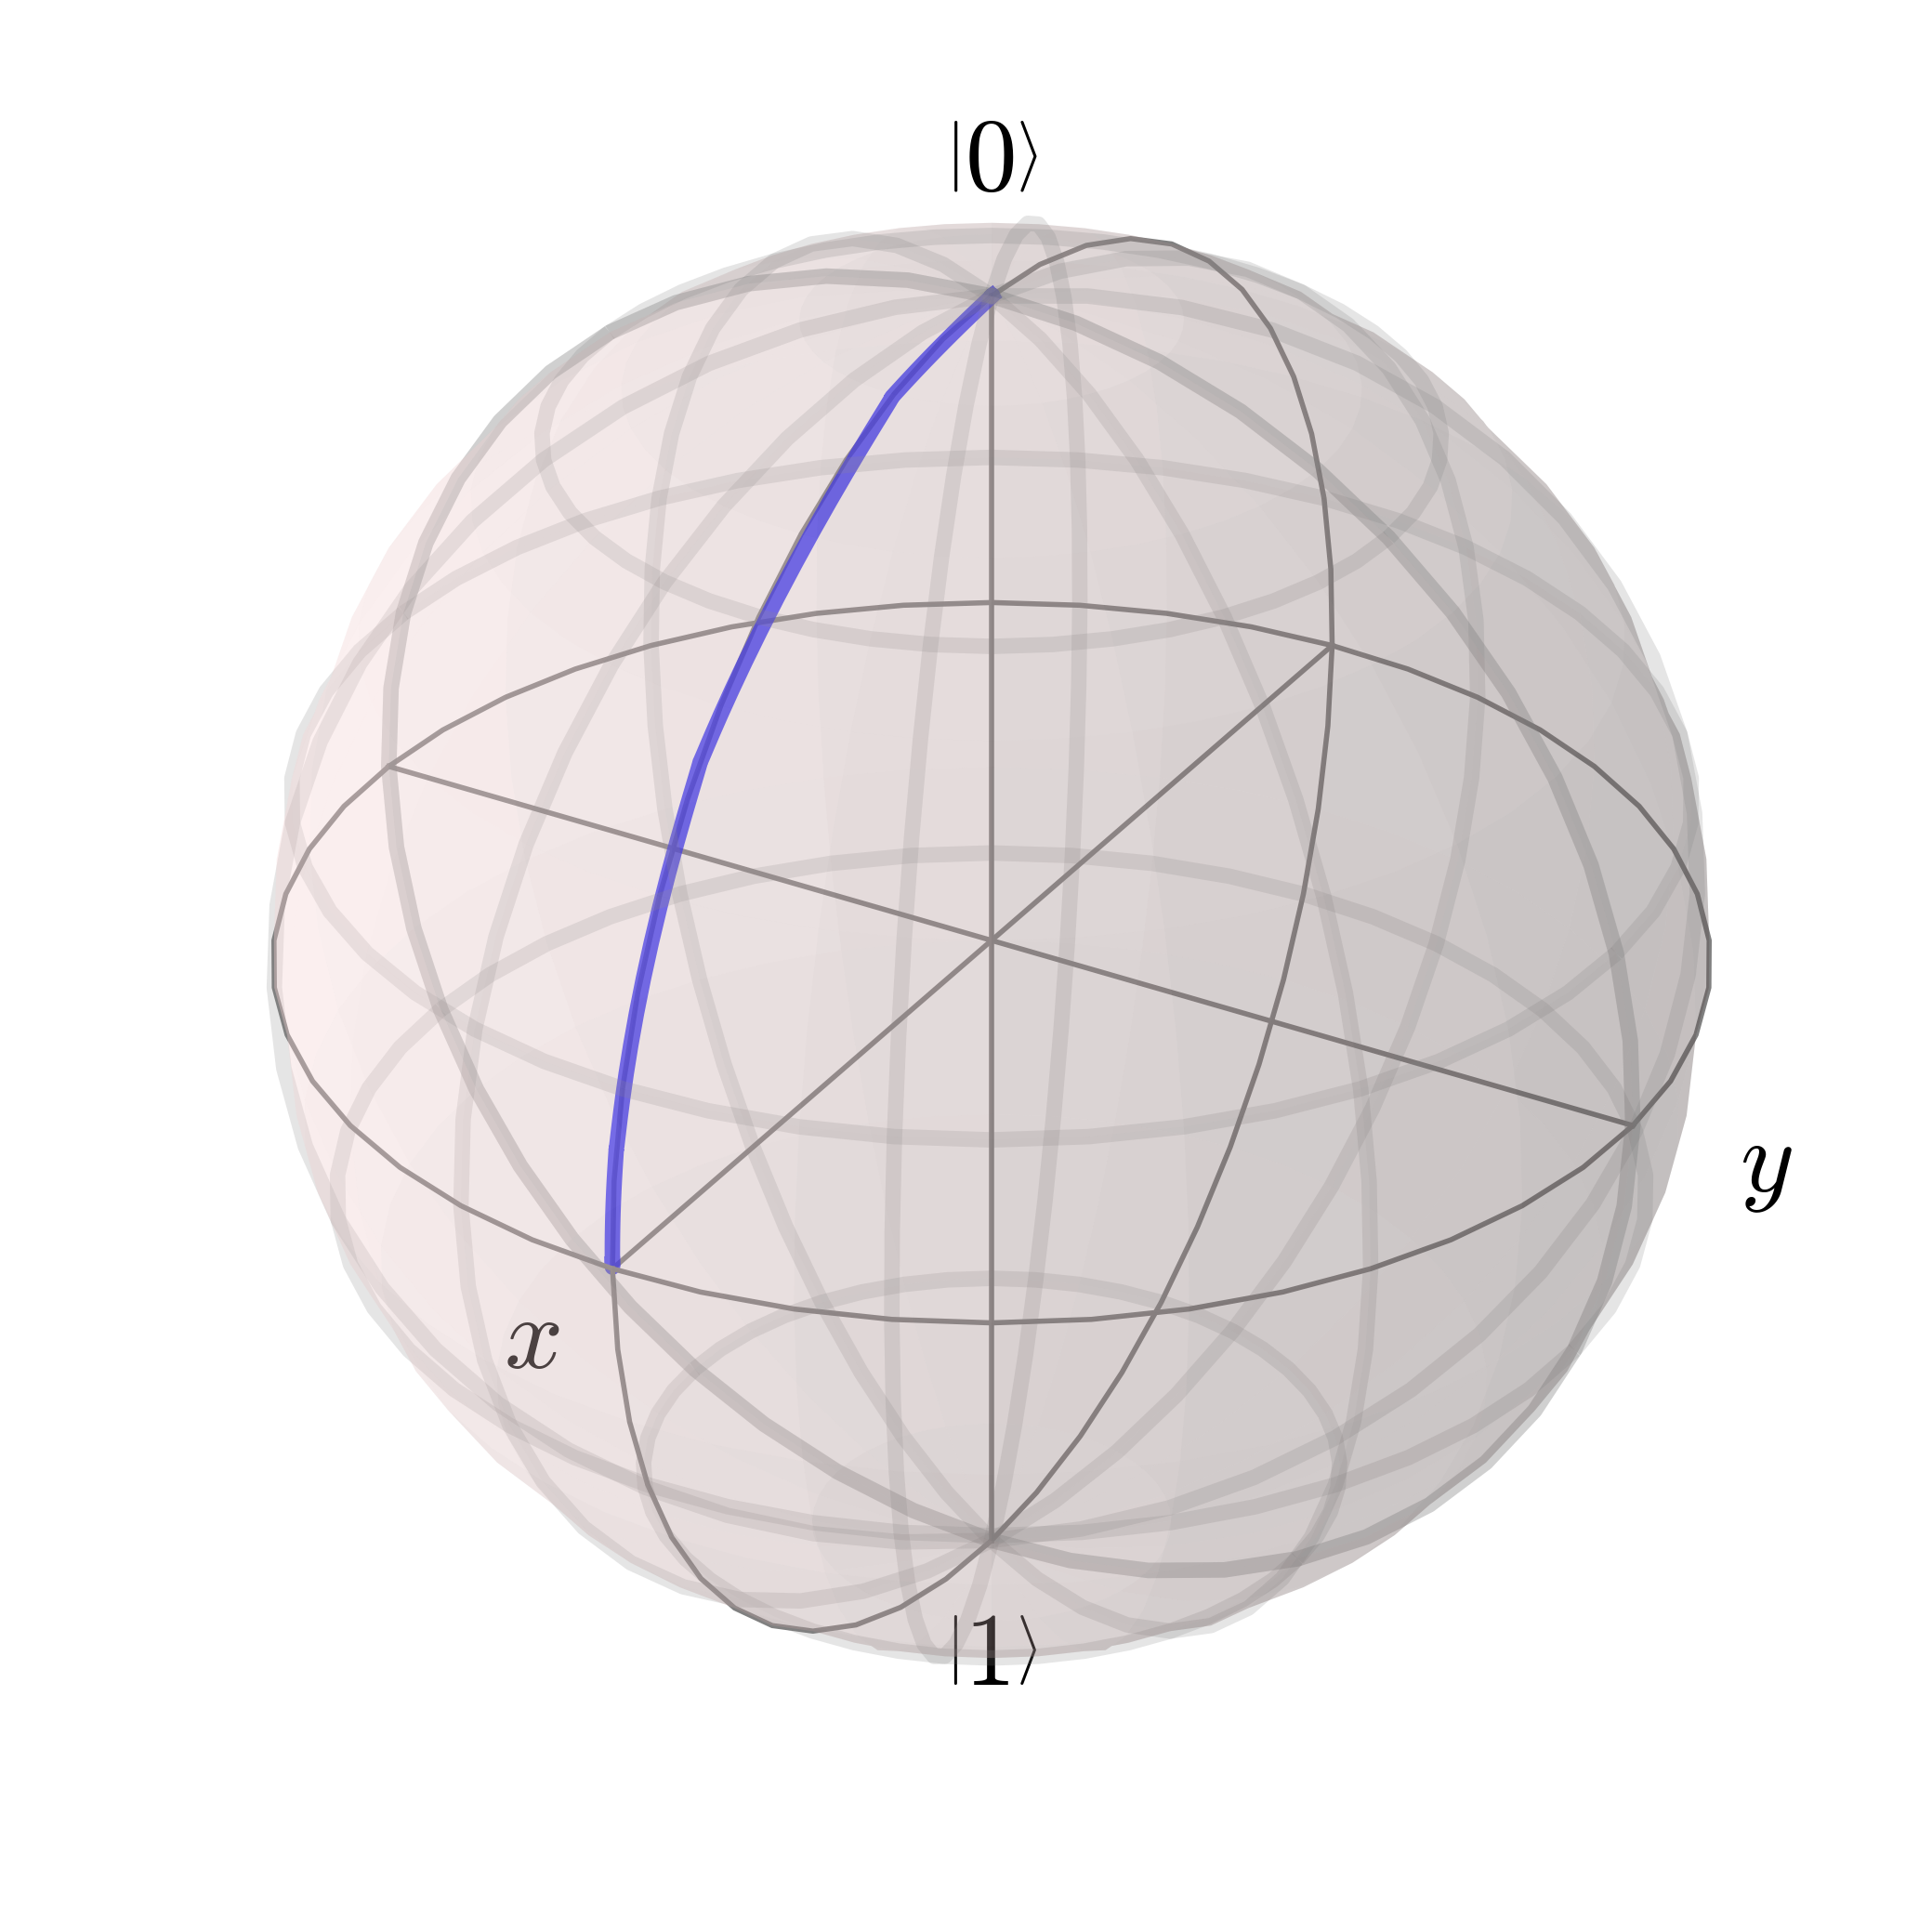

In [130]:
# Trajectory on Bloch sphere
state_evol = U_nothing * U_t * state_0

sz = np.real(expect(state_0*state_0.dag() - state_1*state_1.dag(),state_evol))
sx = np.real(expect(state_0*state_1.dag()+state_0*state_1.dag(),state_evol))
sy = np.real(expect(-1j*state_0*state_1.dag() + 1j*state_0*state_1.dag(),state_evol))

b = Bloch()
b.add_points([sx, sy, sz], meth ='l')
b.make_sphere()